# Importing Libraries and Setting Parameters
This cell imports all the necessary Python libraries and sets up key parameters for the trading scanner:

- **yfinance**: For downloading stock price data.
- **pandas**: For data manipulation and analysis.
- **numpy**: For numerical operations.
- **matplotlib.pyplot**: For plotting and visualizations.
- **datetime**: For handling dates and time periods.

It also sets the plotting style to 'fivethirtyeight' for better visuals and enables inline plotting in the notebook. The cell defines standard parameters such as lookback period, moving average windows, RSI and ATR periods, account size, risk per trade, and ATR multiplier. These parameters are used throughout the scanner to control data range, indicator calculations, and risk management.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Plotting style
plt.style.use('fivethirtyeight')
%matplotlib inline

# Standard Parameters
LOOKBACK_YEARS = 1
END_DATE = datetime.datetime.today()
START_DATE = END_DATE - datetime.timedelta(days=LOOKBACK_YEARS*365)
MA_SHORT = 20 # 20-period MA
MA_MED = 50 # 50-period MA
MA_LONG = 200 # 200-period MA
RSI_PERIOD = 14 # 14-period RSI
ATR_PERIOD = 14 # 14-period ATR
VOL_MA_PERIOD = 20 # 20-period Volatility MA

ACCOUNT_SIZE = 3000 # $3000 account size
RISK_PER_TRADE = 0.20 # 20% of account size
ATR_MULTIPLIER = 2.0 # 2x ATR

# Fetching Ticker Symbols and Sectors
This cell defines functions to fetch and organize ticker symbols and their sectors for both the S&P 500 (US) and TSX (Canada) stock markets:

- **TICKER_SECTORS**: A global dictionary to map each ticker symbol to its sector.
- **get_sp500_tickers_and_sectors()**: Scrapes the S&P 500 company list from Wikipedia, extracting ticker symbols and their sectors, and populates the global map.
- **get_tsx_tickers_and_sectors()**: Scrapes the TSX Composite Index from Wikipedia, extracting ticker symbols (with ".TO" suffix) and their sectors, and updates the global map.
- Both functions handle errors gracefully and return a default list if scraping fails.
- The code then fetches both lists, combines them into a single `TICKERS` list, and prints the number of tickers loaded for further analysis.

In [2]:
# Global map to hold ticker to sector mapping
TICKER_SECTORS = {}

def get_sp500_tickers_and_sectors():
    """Scrapes Symbol and Sector from Wikipedia"""
    try:
        import requests
        import io
        url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers)
        df = pd.read_html(io.StringIO(response.text))[0]
        
        # Populate the global map
        for index, row in df.iterrows():
            sym = row['Symbol'].replace('.', '-')
            sector = row['GICS Sector']
            TICKER_SECTORS[sym] = sector
            
        return list(TICKER_SECTORS.keys())
    except Exception as e:
        print(f"Error fetching S&P 500: {e}")
        return ['SPY', 'AAPL', 'MSFT']

def get_tsx_tickers_and_sectors():
    """Scrapes Symbol and Sector from Wikipedia for TSX"""
    try:
        import requests
        import io
        url = 'https://en.wikipedia.org/wiki/S%26P/TSX_Composite_Index'
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers)
        
        # Find table with 'Ticker' column
        tables = pd.read_html(io.StringIO(response.text))
        df = next(t for t in tables if 'Ticker' in t.columns)
        
        print("TSX columns:", df.columns)

        tickers = []
        # Find the sector column dynamically
        sector_col = None
        for col in df.columns:
            if 'sector' in col.lower():
                sector_col = col
                break

        for index, row in df.iterrows():
            sym = str(row['Ticker']).replace('.', '-')
            if sector_col and pd.notnull(row[sector_col]):
                sector = row[sector_col]
            else:
                sector = 'Canadian Market'
            sym_to = sym + ".TO"
            TICKER_SECTORS[sym_to] = sector
            tickers.append(sym_to)

        return tickers

    except Exception as e:
        print(f"Error fetching TSX list: {e}")
        return ['SHOP.TO', 'RY.TO', 'TD.TO']

# Load Both Lists
print("Fetching tickers and sectors...")
sp500 = get_sp500_tickers_and_sectors()
tsx = get_tsx_tickers_and_sectors()

# Combine them
TICKERS = sp500 + tsx

print(f"Loaded {len(sp500)} US and {len(tsx)} Canadian tickers. Total: {len(TICKERS)}")

sample_items = list(TICKER_SECTORS.items())[:3]
df_sample = pd.DataFrame(sample_items, columns=["Ticker", "Sector"])
print("Ticker to Sector mapping sample:")
display(df_sample)

# TSX Ticker to Sector mapping sample (first 3)
tsx_head = [ticker for ticker in TICKER_SECTORS if ticker.endswith('.TO')]
tsx_sample = [(ticker, TICKER_SECTORS[ticker]) for ticker in tsx_head[:3]]
df_tsx_sample = pd.DataFrame(tsx_sample, columns=["TSX Ticker", "Sector"])
print("TSX Ticker to Sector mapping sample:")
display(df_tsx_sample)

Fetching tickers and sectors...
TSX columns: Index(['Ticker', 'Company', 'Sector [9]', 'Industry [9]'], dtype='object')
Loaded 503 US and 223 Canadian tickers. Total: 726
Ticker to Sector mapping sample:


,Ticker,Sector
0,MMM,Industrials
1,AOS,Industrials
2,ABT,Health Care


TSX Ticker to Sector mapping sample:


,TSX Ticker,Sector
0,AAV.TO,Energy
1,AEM.TO,Basic Materials
2,AC.TO,Industrials


# Core Functions for Data Processing and Strategy Application

This cell defines the core functions that power the swing trading scanner:

- **`download_data(tickers, start, end)`**: Downloads historical OHLCV (Open, High, Low, Close, Volume) data for a list of ticker symbols using the yfinance library. It handles bulk downloads efficiently, cleans the data by removing NaN values, and returns a dictionary of DataFrames keyed by ticker symbol. This function is crucial for fetching the raw market data needed for analysis.

- **`calculate_indicators(df)`**: Adds a comprehensive set of technical indicators to a stock's DataFrame. These include moving averages (SMA 20, 50, 200), volume metrics (SMA of volume and relative volume), momentum indicators (RSI, MACD), volatility measures (Bollinger Bands, ATR), oscillators (Stochastic K/D), trend strength (ADX), cycle indicators (CCI), and anchored VWAP. It also computes returns and rolling highs for filtering purposes. This function transforms raw price data into actionable technical signals.

- **`check_market_regime(market_ticker='SPY', start_date=START_DATE, end_date=END_DATE)`**: Evaluates the overall market trend by comparing the market index (default SPY) to its 200-period simple moving average. It returns True if the market is in an uptrend (price above 200 SMA), which influences the probability of successful long trades. This helps filter out setups during bearish market conditions.

- **`apply_strategies(df)`**: Implements four swing trading strategies by defining boolean conditions for each:
  1. **Breakout**: Identifies strong upward breakouts above 20-day highs with high volume and trend strength (ADX > 20).
  2. **Pullback**: Finds dips near the 20 SMA in an uptrending market (20 > 50 > 200 SMAs) with moderate volume and RSI in a neutral range.
  3. **Mean Reversion**: Spots oversold bounces below the lower Bollinger Band with Stochastic K < 20, above the 200 SMA.
  4. **Retest**: Detects pullbacks to recently broken resistance levels with drying volume, indicating potential continuation.

These functions work together to process raw data, compute indicators, assess market conditions, and generate trading signals, forming the backbone of the automated scanner.

In [ ]:
def download_data(tickers, start, end):
    """Downloads daily OHLCV data for a list of tickers using yfinance.
    Returns a dictionary of DataFrames."""
    data_dict = {}
    print(f"Downloading data for {len(tickers)} tickers...")

    try:
        raw_data = yf.download(
            tickers,
            start=start,
            end=end,
            group_by="ticker",
            auto_adjust=False,
            threads=True,
            progress=False,
        )

        for ticker in tickers:
            # Handle case where only one ticker is downloaded
            if len(tickers) == 1:
                if isinstance(raw_data.columns, pd.MultiIndex):
                    df = raw_data[ticker].copy()
                else:
                    df = raw_data.copy()
            else:
                if ticker not in raw_data.columns.levels[0]:
                    continue
                df = raw_data[ticker].copy()

            df.dropna(inplace=True)
            if df.empty:
                continue

            data_dict[ticker] = df

    except Exception as e:
        print(f"Error downloading data: {e}")

    print(f"Successfully loaded {len(data_dict)} tickers.")
    return data_dict


def calculate_indicators(df):
    """Adds technical indicators to the DataFrame (Pro Version).

    Includes: SMA, Volume SMA, Wilder RSI, MACD, Bollinger Bands,
    Wilder ATR, Stochastics, Wilder ADX, CCI, and AVWAP scaffolding.
    """
    if df.empty:
        return df

    df = df.copy()

    # Constants
    MA_SHORT = 20
    MA_MED = 50
    MA_LONG = 200
    RSI_PERIOD = 14
    ATR_PERIOD = 14
    VOL_MA_PERIOD = 20

    # 1. Moving Averages
    df[f"SMA_{MA_SHORT}"] = df["Close"].rolling(window=MA_SHORT).mean()
    df[f"SMA_{MA_MED}"] = df["Close"].rolling(window=MA_MED).mean()
    df[f"SMA_{MA_LONG}"] = df["Close"].rolling(window=MA_LONG).mean()

    # 2. Volume Moving Average
    df["Vol_SMA"] = df["Volume"].rolling(window=VOL_MA_PERIOD).mean()
    df["Rel_Vol"] = df["Volume"] / df["Vol_SMA"]

    # 3. RSI (Wilder)
    delta = df["Close"].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.ewm(alpha=1 / RSI_PERIOD, adjust=False, min_periods=RSI_PERIOD).mean()
    avg_loss = loss.ewm(alpha=1 / RSI_PERIOD, adjust=False, min_periods=RSI_PERIOD).mean()
    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))

    # 4. MACD (Momentum)
    ema12 = df["Close"].ewm(span=12, adjust=False).mean()
    ema26 = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD"] = ema12 - ema26
    df["MACD_Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()
    df["MACD_Hist"] = df["MACD"] - df["MACD_Signal"]

    # 5. Bollinger Bands (20, 2)
    std_dev = df["Close"].rolling(window=20).std()
    df["BB_Upper"] = df[f"SMA_{MA_SHORT}"] + (2 * std_dev)
    df["BB_Lower"] = df[f"SMA_{MA_SHORT}"] - (2 * std_dev)

    # 6. ATR (Wilder)
    high_low = df["High"] - df["Low"]
    high_close = np.abs(df["High"] - df["Close"].shift())
    low_close = np.abs(df["Low"] - df["Close"].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    df["ATR"] = true_range.ewm(alpha=1 / ATR_PERIOD, adjust=False, min_periods=ATR_PERIOD).mean()

    # 7. Slow Stochastics (14, 3)
    low_14 = df["Low"].rolling(window=14).min()
    high_14 = df["High"].rolling(window=14).max()
    df["Stoch_K"] = 100 * ((df["Close"] - low_14) / (high_14 - low_14))
    df["Stoch_D"] = df["Stoch_K"].rolling(window=3).mean()

    # 8. ADX (Wilder DM/ADX)
    up_move = df["High"] - df["High"].shift(1)
    down_move = df["Low"].shift(1) - df["Low"]
    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)

    adx_period = 14
    tr = true_range
    tr_ewm = tr.ewm(alpha=1 / adx_period, adjust=False).mean()
    plus_dm_ewm = pd.Series(plus_dm, index=df.index).ewm(alpha=1 / adx_period, adjust=False).mean()
    minus_dm_ewm = pd.Series(minus_dm, index=df.index).ewm(alpha=1 / adx_period, adjust=False).mean()

    plus_di = 100 * (plus_dm_ewm / tr_ewm.replace(0, np.nan))
    minus_di = 100 * (minus_dm_ewm / tr_ewm.replace(0, np.nan))
    dx = (np.abs(plus_di - minus_di) / (plus_di + minus_di).replace(0, np.nan)) * 100
    df["Plus_DI"] = plus_di
    df["Minus_DI"] = minus_di
    df["ADX"] = dx.ewm(alpha=1 / adx_period, adjust=False).mean()

    # 9. CCI
    tp = (df["High"] + df["Low"] + df["Close"]) / 3
    sma_tp = tp.rolling(window=20).mean()
    mad = tp.rolling(window=20).apply(lambda x: np.abs(x - x.mean()).mean())
    df["CCI"] = (tp - sma_tp) / (0.015 * mad)

    # 10. Anchored VWAP scaffolding
    vwap_tp = (df["High"] + df["Low"] + df["Close"]) / 3
    vp = vwap_tp * df["Volume"]
    df["_Cum_PV"] = vp.cumsum()
    df["_Cum_Vol"] = df["Volume"].cumsum()
    df["AVWAP_Global"] = df["_Cum_PV"] / df["_Cum_Vol"]
    df["AVWAP"] = df["AVWAP_Global"]  # backward-compatible alias

    # Structure helpers
    df["Ret_1d"] = df["Close"].pct_change()
    df["Ret_3m"] = df["Close"].pct_change(63)
    df["High_20d"] = df["High"].rolling(window=20).max()
    df["Low_10d"] = df["Low"].rolling(window=10).min()
    df["Low_Close_20d"] = df["Close"].rolling(window=20).min()

    return df


def check_market_regime(market_ticker="SPY", start_date=START_DATE, end_date=END_DATE):
    """Checks if the broad market is in a long-term uptrend (Close > 200 SMA)."""
    print(f"Checking market regime for {market_ticker}...")
    try:
        print(f"Downloading data for {market_ticker} from {start_date} to {end_date}...")
        df = yf.download(market_ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
        print(f"Downloaded data shape: {df.shape}")
        print(f"Data columns: {df.columns}")
        print(f"Data empty? {df.empty}")

        if isinstance(df.columns, pd.MultiIndex):
            print("Handling MultiIndex columns...")
            df = df.xs(market_ticker, axis=1, level=1)
            print(f"After xs: shape {df.shape}, columns {df.columns}")

        if df.empty:
            raise ValueError(f"No data downloaded for {market_ticker}")

        df["SMA_200"] = df["Close"].rolling(window=200).mean()
        latest = df.iloc[-1]

        is_uptrend = latest["Close"] > latest["SMA_200"]
        status = "BULLISH" if is_uptrend else "BEARISH"
        print(f"Market Status: {status} (Price: {latest['Close']:.2f} vs 200 SMA: {latest['SMA_200']:.2f})")

        if not is_uptrend:
            print("WARNING: Market is in a downtrend. Long setups have lower probability.")

        return is_uptrend
    except Exception as e:
        print(f"Error checking market regime: {e}")
        print(f"Exception type: {type(e)}")
        import traceback
        traceback.print_exc()
        return True


def apply_strategies(df):
    """Define boolean signals for swing trading setups.

    1. Breakout (Strong Vol, ADX > 20)
    2. Pullback (Super Trend, 20 SMA dip, RSI Reset)
    3. Mean Reversion (BB Lower + Oversold)
    4. Breakout Retest (Base -> Breakout -> Retest of Support)
    """
    if df.empty:
        return df

    MA_SHORT = 20
    MA_MED = 50
    MA_LONG = 200

    # 1. Breakout Setup
    breakout_cond = (
        (df["Close"] >= df["High_20d"].shift(1))
        & (df["Rel_Vol"] > 2)
        & (df["Close"] > df[f"SMA_{MA_MED}"])
        & (df["Close"] > df["Open"])
        & (df["ADX"] > 20)
    )

    # 2. Pullback in Super Trend
    super_trend = (
        (df[f"SMA_{MA_SHORT}"] > df[f"SMA_{MA_MED}"])
        & (df[f"SMA_{MA_MED}"] > df[f"SMA_{MA_LONG}"])
    )

    near_20sma = (df["Low"] <= df[f"SMA_{MA_SHORT}"]) & (
        df["Close"] > df[f"SMA_{MA_SHORT}"] * 0.98
    )

    rsi_reset = (df["RSI"] > 40) & (df["RSI"] < 60)
    vol_check = (df["Rel_Vol"] > 0.25) & (df["Rel_Vol"] < 1.5)

    sma20_slope_up = df[f"SMA_{MA_SHORT}"] > df[f"SMA_{MA_SHORT}"].shift(10)

    atr_pct = df["ATR"] / df["Close"]
    atr_sane = atr_pct < 0.04  # avoid crazy-high vol
    atr_not_too_tiny = atr_pct > 0.006  # avoid ultra-compressed noise (<0.6%)

    pullback_cond = (
        super_trend
        & near_20sma
        & rsi_reset
        & vol_check
        & sma20_slope_up
        & atr_sane
        & atr_not_too_tiny
    )

    # 3. Mean Reversion
    touched_band = (df["Low"] <= df["BB_Lower"]) | (
        df["Low"].shift(1) <= df["BB_Lower"].shift(1)
    )
    stoch_oversold = df["Stoch_K"] < 20
    mean_rev_cond = touched_band & stoch_oversold & (df["Close"] > df[f"SMA_{MA_LONG}"])

    # 4. Base -> Breakout -> Retest (Refined)
    resistance_level = df["High"].shift(10).rolling(window=50).max()

    price_range = df["High"] - df["Low"]
    avg_range_20 = price_range.rolling(window=20).mean()
    range_expansion = price_range > (avg_range_20 * 1.3)
    volume_expansion = df["Rel_Vol"] > 1.5

    raw_breakout = (
        (df["Close"] > resistance_level * 1.02)
        & (volume_expansion | range_expansion)
    )
    was_breakout = raw_breakout.rolling(window=10).max().astype(bool)

    near_resistance = (
        (df["Close"] >= resistance_level * 0.97)
        & (df["Close"] <= resistance_level * 1.03)
    )

    recent_high = df["Close"].rolling(window=10).max()
    is_pullback_action = df["Close"] < recent_high

    above_res = df["Close"] > resistance_level
    held_above = above_res.shift(1).rolling(window=3).sum() >= 2

    dry_volume = df["Rel_Vol"] < 1.2

    retest_cond = (
        was_breakout
        & near_resistance
        & is_pullback_action
        & dry_volume
        & held_above
        & (df["Close"] > df[f"SMA_{MA_LONG}"])
    )

    df["Signal_Breakout"] = breakout_cond
    df["Signal_Pullback"] = pullback_cond
    df["Signal_MeanRev"] = mean_rev_cond
    df["Signal_Retest"] = retest_cond

    # Store breakout pivot when breakout signal triggers
    df["Breakout_Pivot"] = np.nan
    breakout_mask = df["Signal_Breakout"]
    if breakout_mask.any():
        df.loc[breakout_mask, "Breakout_Pivot"] = df.loc[breakout_mask, "High"]
        df["Breakout_Pivot"] = df["Breakout_Pivot"].ffill()

    return df


def add_anchored_vwaps(df):
    """Add context-aware anchored VWAPs.

    - AVWAP_Global: from start of dataset.
    - AVWAP_Breakout: anchored to most recent breakout candle.
    - AVWAP_Pullback: anchored to most recent pivot swing low.
    """
    if df.empty:
        return df

    df = df.copy()

    if "_Cum_PV" not in df.columns or "_Cum_Vol" not in df.columns:
        tp = (df["High"] + df["Low"] + df["Close"]) / 3
        vp = tp * df["Volume"]
        df["_Cum_PV"] = vp.cumsum()
        df["_Cum_Vol"] = df["Volume"].cumsum()

    cum_pv = df["_Cum_PV"]
    cum_vol = df["_Cum_Vol"]

    def _anchored_series(anchor_loc: int | None):
        if anchor_loc is None:
            return pd.Series(index=df.index, dtype=float)
        if anchor_loc == 0:
            numer = cum_pv
            denom = cum_vol
        else:
            pre_pv = cum_pv.iloc[anchor_loc - 1]
            pre_vol = cum_vol.iloc[anchor_loc - 1]
            numer = cum_pv - pre_pv
            denom = cum_vol - pre_vol
        avwap = numer / denom.replace(0, np.nan)
        avwap.iloc[:anchor_loc] = np.nan
        return avwap

    # Breakout anchor
    if "Signal_Breakout" in df.columns:
        breakout_indices = df.index[df["Signal_Breakout"]].tolist()
        if breakout_indices:
            last_breakout_idx = breakout_indices[-1]
            anchor_loc = df.index.get_loc(last_breakout_idx)
            df["AVWAP_Breakout"] = _anchored_series(anchor_loc)

    # Pullback anchor: pivot swing low (fractals)
    lookback = 3
    pivot_window = 2 * lookback + 1
    pivot_low = df["Low"].rolling(window=pivot_window, center=True).min()
    pivot_low_mask = df["Low"] == pivot_low
    pivot_low_indices = df.index[pivot_low_mask].tolist()
    if pivot_low_indices:
        last_pivot_idx = pivot_low_indices[-1]
        anchor_loc = df.index.get_loc(last_pivot_idx)
        df["AVWAP_Pullback"] = _anchored_series(anchor_loc)

    return df

# Sector Analysis and Market Context

This cell performs sector-level analysis to enhance the stock scanner by incorporating market context and relative strength:

- **Sector ETF Mapping**: Defines a dictionary (`SECTOR_ETF_MAP`) that maps each stock sector (e.g., Technology, Health Care) to its corresponding sector ETF proxy (e.g., XLK for Technology, XLV for Health Care). This allows comparing individual stocks against their sector performance.

- **Market Regime Check**: Calls the `check_market_regime()` function to determine if the overall market (using SPY) is in an uptrend. This global context helps filter setups during bearish periods when long trades have lower success rates.

- **Sector Data Download**: Downloads historical data for all sector ETFs plus market indices (SPY for US, XIU.TO for Canada) using the `download_data()` function. This provides the foundation for sector performance calculations.

- **Sector Performance Calculation**: For each sector ETF, computes 3-month returns and checks if the ETF is above its 50-day SMA to determine short-term trend direction. Stores this in `sector_performance` dictionary, which will be used later to score stocks based on sector strength.

This analysis ensures that the scanner prioritizes stocks in strong sectors and avoids those in weak ones, improving the quality of trade setups by considering broader market dynamics.

In [4]:
# --- Sector Analysis ---
print("\n--- Sector Analysis ---")

# Map Sector Names to their ETF Proxies
SECTOR_ETF_MAP = {
    'Energy': 'XLE',
    'Information Technology': 'XLK',
    'Technology': 'XLK',
    'Communication Services': 'XLC',
    'Consumer Discretionary': 'XLY',
    'Consumer Staples': 'XLP',
    'Financials': 'XLF',
    'Financial Services': 'XLF',
    'Health Care': 'XLV',
    'Industrials': 'XLI',
    'Materials': 'XLB',
    'Basic Materials': 'XLB',
    'Real Estate': 'XLRE',
    'Utilities': 'XLU'
}
# Check Market Regime
market_uptrend = check_market_regime('SPY', START_DATE, END_DATE)

# --- Pre-Fetch Sector Data ---
print("Downloading Sector ETF Data...")

sector_etfs = list(set(SECTOR_ETF_MAP.values())) + ['SPY', 'XIU.TO']
sector_data = download_data(sector_etfs, START_DATE, END_DATE)

# Calculate Sector Momentum (3-Month Return)
sector_performance = {}

for etf, df in sector_data.items():
    if not df.empty:
        df['Ret_3m'] = df['Close'].pct_change(63)
        current_perf = df['Ret_3m'].iloc[-1]
        
        # Detect Short Term Trend (Price > 50 SMA)
        sma50 = df['Close'].rolling(50).mean().iloc[-1]
        is_uptrend = df['Close'].iloc[-1] > sma50
        
        sector_performance[etf] = {
            'Ret_3m': current_perf,
            'Uptrend': is_uptrend
        }
# Clearer print with explanations
print("\nSector Performance (Dual Criteria for Clarity):")
print("Note: 'BULL' = Current price > 50-day SMA (short-term trend up). 'BEAR' = Otherwise.")
print("3M Return is separate (longer-term performance). A sector can be 'BULL' even with negative returns if price > SMA.")
print("-" * 80)
print("\nSector Performance (3M):")
for etf, stats in sector_performance.items():
    trend = "BULL" if stats['Uptrend'] else "BEAR"
    print(f"{etf}: {stats['Ret_3m']*100:.1f}% ({trend})")


--- Sector Analysis ---
Checking market regime for SPY...
Downloaded data shape: (251, 5)
Data columns: MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])
Data empty? False
Handling MultiIndex columns...
After xs: shape (251, 5), columns Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
SMA_200 calculated. Last SMA value: 630.7136790466309
Latest row: Price
Close      6.916600e+02
High       6.942500e+02
Low        6.901000e+02
Open       6.936600e+02
Volume     7.048313e+07
SMA_200    6.307137e+02
Name: 2026-01-16 00:00:00, dtype: float64
Market Status: BULLISH (Price: 691.66 vs 200 SMA: 630.71)
Successfully loaded 13 tickers.

Sector Performance (Dual Criteria for Clarity):
Note: 'BULL' = Current price > 50-day SMA (short-term trend up). 'BEAR' = Otherwise.
3M Return is separate (longer-term performance). A secto

# Running the Scanner with Balanced Technical R/R (v2.3)

This cell executes the complete swing trading scanner with **honest but practical** target logic.

## 🔧 Changes in v2.3 (vs v2.2):

### The Problem with v2.2
Pure technical targets were **too strict** for current market conditions:
- 0 Pullback setups (target = 20d high only, often too close to entry)
- Missed valid continuation plays where stocks make new highs

### The Balance: Honest + Practical

| Strategy | v2.2 (Too Strict) | v2.3 (Balanced) | Rationale |
|----------|-------------------|-----------------|-----------|
| **Pullback** | 20d high only | 20d high + 0.75 ATR | Pullbacks expect continuation beyond prior highs |
| **Pullback Stop** | 2x ATR | 1.5x ATR | Tighter stop at support = better R/R |
| **Retest** | 20d high + 0.75 ATR | Unchanged | Already reasonable |
| **Mean Rev** | 20 SMA only | 20 SMA + 0.5 ATR | Bounces often overshoot the mean |
| **Breakout** | 2x candle range | Unchanged | Already reasonable |

### Key Philosophy
- **Pullbacks/Retests are continuation plays** → They expect new highs, not just a return to old highs
- **Stops should reflect where the trade is WRONG** → At 20 SMA support, 1.5x ATR is sufficient
- **Mean reversion bounces overshoot** → A small extension is statistically realistic

### Scoring System (Max 100 points)

| Tier | Category | Max Points | Description |
|------|----------|------------|-------------|
| 1 | Trend Quality | 25 | Price > 200 SMA (+15), All MAs aligned (+10) |
| 2 | Sector Strength | 20 | Sector uptrend (+10), 5%+ return (+5), 10%+ return (+5) |
| 3 | Relative Strength | 25 | Alpha vs sector: >25% (+25), >15% (+20), etc. |
| 4 | Setup Quality | 20 | Strategy-specific volume/momentum/R/R checks |
| 5 | R/R Quality | 10 | 4.0+ R/R (+10), 3.5+ (+8), 3.0+ (+6), 2.5+ (+4), 2.0+ (+2) |
| 6 | Momentum | 10 | MACD bullish (+5), ADX > 25 for trends (+5) |

### Expected Impact vs v2.2
- **More Pullback setups** (the bread-and-butter swing strategy)
- **R/R still varies honestly** (2.1, 2.5, 3.2, etc. — no artificial floors)
- **Better balance** between selectivity and opportunity

In [10]:
# Constants for Filtering
MIN_RR = 2.0
MIN_DOL_VOL = 10_000_000
# Anti micro-stop defaults (swing, not scalper)
MIN_ATR_MULT = 0.8     # minimum stop distance in ATRs
MIN_RISK_PCT = 1.0     # minimum stop distance as % of price

results = []

# Force fresh calculation (for updated indicators)
if "raw_data_dict" in locals():
    del raw_data_dict
if "data_store" in locals():
    del data_store

data_store = {}

print("Running Pro Scanner v3.0 (Wilder RSI/ADX/ATR, Anchored VWAP, Dual Targets, Regime-aware)...")

# 1. Download Stocks (if not cached)
if "raw_data_dict" not in locals():
    raw_data_dict = download_data(TICKERS, START_DATE, END_DATE)

# 2. Process each ticker
for ticker, df in raw_data_dict.items():
    # Skip insufficient data
    if len(df) < MA_LONG:
        continue

    df = calculate_indicators(df)

    # Liquidity Filter
    avg_dollar_vol = (df["Close"] * df["Volume"]).rolling(20).mean().iloc[-1]
    if avg_dollar_vol < MIN_DOL_VOL:
        continue

    # Apply strategies
    df = apply_strategies(df)
    df = add_anchored_vwaps(df)
    data_store[ticker] = df
    latest = df.iloc[-1]

    signals = []
    if latest["Signal_Breakout"]:
        signals.append("Breakout")
    if latest["Signal_Pullback"]:
        signals.append("Pullback")
    if latest["Signal_MeanRev"]:
        signals.append("Mean Reversion")
    if latest["Signal_Retest"]:
        signals.append("Retest")

    for active_signal in signals:
        entry = float(latest["Close"])
        atr = float(latest["ATR"])
        atr_pct = atr / entry if entry != 0 else np.nan

        if np.isnan(atr_pct):
            continue

        # Volatility regime → ATR buffer size
        if atr_pct < 0.02:
            atr_buffer_mult = 0.25
        elif atr_pct < 0.05:
            atr_buffer_mult = 0.50
        else:
            atr_buffer_mult = 0.75

        swing_low_10d = float(latest["Low_10d"])
        sma20 = float(latest[f"SMA_{MA_SHORT}"])
        swing_low_close_20d = float(latest.get("Low_Close_20d", swing_low_10d))

        if active_signal == "Mean Reversion":
            stop = entry - (atr * 1.5)
        elif active_signal in ["Retest", "Pullback"]:
            structure_ref = min(swing_low_10d, swing_low_close_20d, sma20)
            structure_stop = structure_ref - (atr * atr_buffer_mult)
            atr_stop = entry - (atr * 2.2)
            stop = max(structure_stop, atr_stop)
        else:  # Breakout
            stop = entry - (atr * (2.0 + (atr_buffer_mult - 0.25)))

        risk = entry - stop
        if risk <= 0:
            continue

        # --- Anti "micro-stop" rule for Pullback/Retest ---
        if active_signal in ["Pullback", "Retest"]:
            min_risk_abs = max(atr * MIN_ATR_MULT, entry * (MIN_RISK_PCT / 100.0))
            if (entry - stop) < min_risk_abs:
                stop = entry - min_risk_abs
                risk = entry - stop
                if risk <= 0:
                    continue

        # Supply-aware targets
        target1 = None
        target2 = None

        if active_signal == "Breakout":
            breakout_range = max(float(latest["High"] - latest["Low"]), atr * 1.5)
            base_target = entry + (breakout_range * 2.0)
            target1 = base_target
            target2 = base_target

        elif active_signal == "Pullback":
            swing_high = float(latest["High_20d"])
            target1 = swing_high
            target2 = swing_high + (atr * 0.75)

        elif active_signal == "Retest":
            if pd.notna(latest["Breakout_Pivot"]):
                pivot_high = float(latest["Breakout_Pivot"])
                target1 = pivot_high
                target2 = pivot_high + (atr * 0.75)
            else:
                breakout_level = float(df["High"].rolling(window=20).max().iloc[-1])
                target1 = breakout_level
                target2 = breakout_level + (atr * 0.75)

        else:  # Mean Reversion
            mean_level = float(latest[f"SMA_{MA_SHORT}"])
            if entry >= mean_level:
                continue
            target1 = mean_level
            target2 = mean_level + (atr * 0.5)

        target = target1
        reward = target - entry
        rr_ratio = reward / risk

        # Baseline R/R filter
        if rr_ratio < MIN_RR:
            continue

        # Regime-aware extra filter: in downtrend, demand more edge
        if not market_uptrend and rr_ratio < (MIN_RR + 0.5):
            continue

        rr_true = rr_ratio
        rr_display = min(rr_true, 5.0)

        # --- SECTOR & RS ---
        stock_sector = TICKER_SECTORS.get(ticker, "Unknown")
        default_market = "XIU.TO" if ticker.endswith(".TO") else "SPY"
        benchmark_ticker = SECTOR_ETF_MAP.get(stock_sector, default_market)
        bench_stats = sector_performance.get(benchmark_ticker, {"Ret_3m": 0, "Uptrend": True})
        bench_ret = bench_stats["Ret_3m"]
        stock_ret = latest["Ret_3m"]
        rs_rating = float(stock_ret - bench_ret)  # vs sector ETF

        # Pullback RS gate: negative RS must earn its place via high R/R
        if active_signal == "Pullback" and rs_rating <= 0:
            if rr_true < 3.0:
                continue

        # --- SCORING ENGINE v3.0 ---
        score = 0

        # Tier 1: Trend quality
        if latest["Close"] > latest[f"SMA_{MA_LONG}"]:
            score += 15
            if latest[f"SMA_{MA_SHORT}"] > latest[f"SMA_{MA_MED}"] > latest[f"SMA_{MA_LONG}"]:
                score += 10

        # Tier 2: Sector strength
        if bench_stats["Uptrend"]:
            score += 10
            if bench_ret > 0.05:
                score += 5
            if bench_ret > 0.10:
                score += 5

        # Tier 3: Relative strength
        if rs_rating > 0.25:
            score += 25
        elif rs_rating > 0.15:
            score += 20
        elif rs_rating > 0.10:
            score += 15
        elif rs_rating > 0.05:
            score += 10
        elif rs_rating > 0:
            score += 5
        elif rs_rating < -0.10:
            score -= 15
        elif rs_rating < -0.05:
            score -= 10

        # Tier 4: Setup quality
        if active_signal == "Breakout":
            if latest["Rel_Vol"] > 2.0:
                score += 15
            elif latest["Rel_Vol"] > 1.5:
                score += 10
        elif active_signal == "Pullback":
            if 0.5 <= latest["Rel_Vol"] <= 1.0:
                score += 10
            if 40 <= latest["RSI"] <= 55:
                score += 5
            if rr_true >= 3.0:
                score += 5
        elif active_signal == "Retest":
            if latest["Rel_Vol"] < 0.8:
                score += 10
            if latest["MACD_Hist"] > 0:
                score += 5
        elif active_signal == "Mean Reversion":
            if latest["Stoch_K"] < 25:
                score += 10
            mean_gap_pct = (target2 - entry) / entry * 100 if target2 is not None else 0
            if mean_gap_pct >= 5:
                score += 5

        # Tier 5: R/R quality (true R/R)
        if rr_true >= 4.0:
            score += 10
        elif rr_true >= 3.5:
            score += 8
        elif rr_true >= 3.0:
            score += 6
        elif rr_true >= 2.5:
            score += 4
        elif rr_true >= 2.0:
            score += 2

        # Tier 6: Momentum
        if latest["MACD"] > latest["MACD_Signal"]:
            score += 5
        if latest["ADX"] > 25 and active_signal in ["Breakout", "Pullback"]:
            score += 5

        # Penalties
        if latest["RSI"] > 70 and active_signal != "Breakout":
            score -= 10
        if latest["RSI"] < 30 and active_signal == "Mean Reversion":
            score += 5
        if active_signal == "Pullback" and abs(latest["CCI"]) > 150:
            score -= 5

        # Distance-from-support penalty
        if active_signal in ["Pullback", "Retest"]:
            sma20_local = float(latest[f"SMA_{MA_SHORT}"])
            distance_from_support = entry - sma20_local
            if distance_from_support > (atr * 2.0):
                score -= 15

        risk_pct = (entry - stop) / entry * 100
        if risk_pct > 8:
            score -= 10
        elif risk_pct > 5:
            score -= 5

        # Regime penalty: if broad market not in uptrend, de-weight scores
        if not market_uptrend:
            score -= 15

        score = min(max(score, 0), 100)

        # Position sizing
        risk_per_share = entry - stop
        risk_amount = ACCOUNT_SIZE * RISK_PER_TRADE
        shares = int(risk_amount / risk_per_share) if risk_per_share > 0 else 0
        if shares < 1:
            continue

        results.append(
            {
                "Ticker": ticker,
                "Signal": active_signal,
                "Score": score,
                "Close": round(entry, 2),
                "Stop": round(stop, 2),
                "Target": round(target, 2) if target is not None else None,
                "Target1": round(target1, 2) if target1 is not None else None,
                "Target2": round(target2, 2) if target2 is not None else None,
                "RR": round(rr_true, 2),
                "RR_Display": round(rr_display, 2),
                "Risk%": round(risk_pct, 1),
                "Sector": stock_sector,
                "RS_Sec": round(rs_rating * 100, 1),
                "RS_Mkt": round(
                    (stock_ret - sector_performance[default_market]["Ret_3m"]) * 100, 1
                )
                if default_market in sector_performance
                else 0,
            }
        )

results_df = pd.DataFrame(results)


def score_to_grade(s: float) -> str:
    if s >= 85:
        return "A"
    if s >= 70:
        return "B"
    if s >= 55:
        return "C"
    return "D"

if not results_df.empty:
    results_df["Grade"] = results_df["Score"].apply(score_to_grade)
    results_df = results_df.sort_values(by=["Score", "RR"], ascending=[False, False])
    col_order = [
        "Ticker",
        "Signal",
        "Grade",
        "Score",
        "Close",
        "Stop",
        "Target",
        "Target1",
        "Target2",
        "RR",
        "RR_Display",
        "Risk%",
        "Sector",
        "RS_Sec",
        "RS_Mkt",
    ]
    results_df = results_df[col_order]

    print("\n" + "=" * 80)
    print("1. PULLBACK SETUPS (Pullback to Rising MA)")
    print("=" * 80)
    pullback_df = results_df[results_df["Signal"] == "Pullback"]
    if not pullback_df.empty:
        print(f"Found {len(pullback_df)} Pullback setups")
        display(pullback_df.head(25))
    else:
        print("No Pullback setups found.")

    print("\n" + "=" * 80)
    print("2. RETEST SETUPS (Base → Breakout → Retest)")
    print("=" * 80)
    retest_df = results_df[results_df["Signal"] == "Retest"]
    if not retest_df.empty:
        print(f"Found {len(retest_df)} Retest setups")
        display(retest_df.head(25))
    else:
        print("No Retest setups found.")

    print("\n" + "=" * 80)
    print("3. OTHER SETUPS (Breakout / Mean Reversion)")
    print("=" * 80)
    other_df = results_df[~results_df["Signal"].isin(["Pullback", "Retest"])]
    if not other_df.empty:
        print(f"Found {len(other_df)} other setups")
        display(other_df.head(25))
    else:
        print("No Breakout/Mean Reversion setups found.")

    # Summary
    print("\n" + "-" * 80)
    print("SUMMARY (v3.0 - Regime-aware, true RR, dual targets):")
    print(f"Total Setups: {len(results_df)}")
    print(f"Grade A (85+): {len(results_df[results_df['Score'] >= 85])}")
    print(
        f"Grade B (70-84): {len(results_df[(results_df['Score'] >= 70) & (results_df['Score'] < 85)])}"
    )
    print(
        f"Grade C (55-69): {len(results_df[(results_df['Score'] >= 55) & (results_df['Score'] < 70)])}"
    )
    print(f"Grade D (<55): {len(results_df[results_df['Score'] < 55])}")
    print(f"Avg true R/R (Target1-based): {results_df['RR'].mean():.2f}")
    print(
        f"True R/R Range: {results_df['RR'].min():.2f} - {results_df['RR'].max():.2f}"
    )

    # Market regime context
    print("\n" + "-" * 80)
    print("MARKET REGIME:")
    if market_uptrend:
        print("Broad market in 200-SMA uptrend (risk-on bias).")
    else:
        print("Broad market below 200-SMA (risk-off / counter-trend bias).")

    # Market Context via signal mix
    print("\n" + "-" * 80)
    print("MARKET CONTEXT (signal mix):")
    signal_counts = results_df["Signal"].value_counts()
    for sig, cnt in signal_counts.items():
        print(f"  {sig}: {cnt} setups")

    pullback_count = signal_counts.get("Pullback", 0)
    meanrev_count = signal_counts.get("Mean Reversion", 0)

    if meanrev_count > pullback_count and meanrev_count > 0:
        print("\n⚠️  Mean Reversion > Pullback → Market in correction / choppy conditions.")
    elif pullback_count > meanrev_count:
        if market_uptrend:
            print(
                "\n✅ Pullback > Mean Reversion → Healthy trend environment (within bullish market regime)."
            )
        else:
            print(
                "\n⚠️ Pullback > Mean Reversion but broad market is not in a confirmed uptrend → treat as fragile rally / bear market bounce."
            )

    # High R/R insight (true R/R)
    print("\n" + "-" * 80)
    print("QUALITY INSIGHT (true R/R):")
    high_rr = results_df[results_df["RR"] >= 3.0]
    if len(high_rr) > 0:
        print(f"⭐ High R/R Setups (true R/R ≥ 3.0): {len(high_rr)} candidates")
        for _, row in high_rr.head(5).iterrows():
            print(
                f"   {row['Ticker']} ({row['Signal']}): true R/R {row['RR']:.2f}, display {row['RR_Display']:.2f}, Grade {row['Grade']}"
            )
    else:
        print("   No setups with true R/R ≥ 3.0 today.")
else:
    print(f"No setups found meeting criteria (Min R/R: {MIN_RR}).")

Running Pro Scanner v3.0 (Wilder RSI/ADX/ATR, Anchored VWAP, Dual Targets, Regime-aware)...


$CWB.TO: possibly delisted; no timezone found
$FIL.TO: possibly delisted; no timezone found
$CIX.TO: possibly delisted; no timezone found
$OSK.TO: possibly delisted; no timezone found
$STLC.TO: possibly delisted; no timezone found
$INE.TO: possibly delisted; no timezone found
$SSL.TO: possibly delisted; no timezone found
$MAG.TO: possibly delisted; no timezone found
$SIL.TO: possibly delisted; no timezone found
$NVEI.TO: possibly delisted; no timezone found
$PRMW.TO: possibly delisted; no price data found  (1d 2025-01-16 19:21:09.215517 -> 2026-01-16 19:21:09.215517)
$PKI.TO: possibly delisted; no price data found  (1d 2025-01-16 19:21:09.215517 -> 2026-01-16 19:21:09.215517) (Yahoo error = "No data found, symbol may be delisted")
$CXB.TO: possibly delisted; no timezone found
$VRN.TO: possibly delisted; no timezone found
$NAN.TO: possibly delisted; no timezone found

15 Failed downloads:
['CWB.TO', 'FIL.TO', 'CIX.TO', 'OSK.TO', 'STLC.TO', 'INE.TO', 'SSL.TO', 'MAG.TO', 'SIL.TO', 'NVEI.T

Successfully loaded 711 tickers.


C:\Users\diksh\AppData\Local\Temp\ipykernel_15312\3542267247.py:323: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Breakout_Pivot'] = df['Breakout_Pivot'].fillna(method='ffill')
C:\Users\diksh\AppData\Local\Temp\ipykernel_15312\3542267247.py:323: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Breakout_Pivot'] = df['Breakout_Pivot'].fillna(method='ffill')
C:\Users\diksh\AppData\Local\Temp\ipykernel_15312\3542267247.py:323: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Breakout_Pivot'] = df['Breakout_Pivot'].fillna(method='ffill')
C:\Users\diksh\AppData\Local\Temp\ipykernel_15312\3542267247.py:323: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bf


1. PULLBACK SETUPS (Pullback to Rising MA)
Found 6 Pullback setups


,Ticker,Signal,Grade,Score,Close,Stop,Target,Target1,Target2,RR,RR_Display,Risk%,Sector,RS_Sec,RS_Mkt
1,GM,Pullback,A,87,80.82,79.07,85.18,85.18,86.53,2.49,2.49,2.2,Consumer Discretionary,35.8,36.2
0,AIZ,Pullback,B,74,234.00,230.63,243.76,243.76,246.92,2.90,2.90,1.4,Financials,7.6,8.1
3,PFG,Pullback,C,64,88.48,87.04,92.51,92.51,93.86,2.80,2.80,1.6,Financials,8.4,8.9
6,H.TO,Pullback,C,63,52.73,52.12,54.94,54.94,55.45,3.63,3.63,1.2,Utilities,7.1,-6.2
5,GWO.TO,Pullback,C,62,66.75,65.85,68.56,68.56,69.21,2.02,2.02,1.3,Financial Services,9.1,6.2
4,CCL-B.TO,Pullback,C,61,85.42,84.27,89.11,89.11,90.19,3.21,3.21,1.3,Consumer Cyclical,4.8,4.8



2. RETEST SETUPS (Base → Breakout → Retest)
No Retest setups found.

3. OTHER SETUPS (Breakout / Mean Reversion)
Found 2 other setups


,Ticker,Signal,Grade,Score,Close,Stop,Target,Target1,Target2,RR,RR_Display,Risk%,Sector,RS_Sec,RS_Mkt
2,HIG,Mean Reversion,C,57,129.59,126.39,136.58,136.58,137.65,2.18,2.18,2.5,Financials,-0.6,-0.0
7,MDA.TO,Breakout,D,42,36.29,33.14,43.27,43.27,43.27,2.22,2.22,8.7,Industrials,-7.5,-5.4



--------------------------------------------------------------------------------
SUMMARY (v3.0 - Regime-aware, true RR, dual targets):
Total Setups: 8
Grade A (85+): 1
Grade B (70-84): 1
Grade C (55-69): 5
Grade D (<55): 1
Avg true R/R (Target1-based): 2.68
True R/R Range: 2.02 - 3.63

--------------------------------------------------------------------------------
MARKET REGIME:
Broad market in 200-SMA uptrend (risk-on bias).

--------------------------------------------------------------------------------
MARKET CONTEXT (signal mix):
  Pullback: 6 setups
  Mean Reversion: 1 setups
  Breakout: 1 setups

✅ Pullback > Mean Reversion → Healthy trend environment (within bullish market regime).

--------------------------------------------------------------------------------
QUALITY INSIGHT (true R/R):
⭐ High R/R Setups (true R/R ≥ 3.0): 2 candidates
   H.TO (Pullback): true R/R 3.63, display 3.63, Grade C
   CCL-B.TO (Pullback): true R/R 3.21, display 3.21, Grade C


In [9]:
import numpy as np
import pandas as pd

# --- 0) Get DAY dataframe (use existing if available) ---
ticker = "DAY"

if "data_store" in globals() and ticker in data_store:
    df_day = data_store[ticker].copy()
else:
    # Fallback: rebuild just DAY
    raw = download_data([ticker], START_DATE, END_DATE)
    df_day = calculate_indicators(raw[ticker])
    df_day = apply_strategies(df_day)
    df_day = add_anchored_vwaps(df_day)

# --- 1) Print last ~30 rows of requested columns ---
MA_SHORT = 20
cols = [
    "Close",
    f"SMA_{MA_SHORT}",
    "Low_10d",
    "Low_Close_20d",
    "ATR",
    "Signal_Pullback"
]
print(df_day[cols].tail(30))

# --- 2) Diagnose EXACTLY why risk% was tiny on the latest bar ---
latest = df_day.iloc[-1]

entry = float(latest["Close"])
atr = float(latest["ATR"])
atr_pct = atr / entry if entry else np.nan

sma20 = float(latest[f"SMA_{MA_SHORT}"])
swing_low_10d = float(latest["Low_10d"])
swing_low_close_20d = float(latest.get("Low_Close_20d", np.nan))

# Volatility regime buffer (same as your code)
if np.isnan(atr_pct):
    raise ValueError("ATR% is NaN on latest bar; not enough data or missing ATR.")

if atr_pct < 0.02:
    atr_buffer_mult = 0.25
elif atr_pct < 0.05:
    atr_buffer_mult = 0.50
else:
    atr_buffer_mult = 0.75

structure_ref = min(swing_low_10d, swing_low_close_20d, sma20)
structure_stop = structure_ref - (atr * atr_buffer_mult)
atr_stop = entry - (atr * 2.2)

# Your current stop selection
stop_current = max(structure_stop, atr_stop)
risk_current = entry - stop_current
risk_pct_current = (risk_current / entry) * 100

print("\n--- STOP DIAGNOSTIC (LATEST BAR) ---")
print(f"Entry: {entry:.2f}")
print(f"ATR: {atr:.4f}  (ATR%: {atr_pct*100:.2f}%)")
print(f"SMA20: {sma20:.2f}")
print(f"Low_10d: {swing_low_10d:.2f}")
print(f"Low_Close_20d: {swing_low_close_20d:.2f}")
print(f"atr_buffer_mult: {atr_buffer_mult:.2f}")
print(f"structure_ref (min of refs): {structure_ref:.2f}")
print(f"structure_stop: {structure_stop:.2f}")
print(f"atr_stop (2.2 ATR): {atr_stop:.2f}")

dominant = "STRUCTURE_STOP (tight)" if structure_stop > atr_stop else "ATR_STOP (wider)"
print(f"Chosen stop_current = max(structure_stop, atr_stop): {stop_current:.2f}")
print(f"Dominant component: {dominant}")
print(f"Risk/share: {risk_current:.4f}  Risk%: {risk_pct_current:.2f}%")

# --- 3) Robust stop rule to avoid ultra-tight "fake 5R" stops ---
# Rule: for Pullback/Retest require minimum stop distance:
#   - at least 0.8 ATR OR at least 1.0% (whichever is larger)
MIN_ATR_MULT = 0.8
MIN_RISK_PCT = 1.0  # 1%

min_risk_abs = max(atr * MIN_ATR_MULT, entry * (MIN_RISK_PCT / 100.0))

# If current risk is too small, widen stop downwards to meet minimum risk
if risk_current < min_risk_abs:
    stop_robust = entry - min_risk_abs
else:
    stop_robust = stop_current

risk_robust = entry - stop_robust
risk_pct_robust = (risk_robust / entry) * 100

print("\n--- ROBUST STOP (ANTI-FAKE-RR) ---")
print(f"Min risk required: {min_risk_abs:.4f}  (~{(min_risk_abs/entry)*100:.2f}%)")
print(f"stop_robust: {stop_robust:.2f}")
print(f"Risk/share: {risk_robust:.4f}  Risk%: {risk_pct_robust:.2f}%")


Price           Close   SMA_20    Low_10d  Low_Close_20d       ATR  \
Date                                                                 
2025-12-04  69.110001  68.9110  68.809998      68.349998  0.212688   
2025-12-05  69.070000  68.9385  68.809998      68.349998  0.209639   
2025-12-08  69.029999  68.9725  68.870003      68.599998  0.208593   
2025-12-09  68.949997  68.9900  68.904999      68.800003  0.205479   
2025-12-10  69.150002  69.0075  68.904999      68.830002  0.217588   
2025-12-11  69.160004  69.0160  68.904999      68.830002  0.209546   
2025-12-12  69.260002  69.0335  68.904999      68.830002  0.203150   
2025-12-15  69.290001  69.0480  68.904999      68.830002  0.199353   
2025-12-16  69.199997  69.0665  68.904999      68.849998  0.198685   
2025-12-17  69.220001  69.0790  68.904999      68.849998  0.195208   
2025-12-18  69.269997  69.0940  68.904999      68.849998  0.189835   
2025-12-19  69.269997  69.1140  68.904999      68.849998  0.183418   
2025-12-22  69.18000

# Earnings Risk Management Filter

This cell implements a critical risk management step by filtering out stocks with upcoming earnings announcements that could introduce unpredictable volatility:

- **`has_upcoming_earnings(symbol, days_threshold=7)`**: A robust function that checks if a stock has earnings scheduled within the next 7 days. It uses yfinance's calendar data to fetch earnings dates, handles various data structure formats, and returns whether the stock is unsafe for trading along with the number of days until earnings.

- **Filtering Process**: Iterates through all scanner results, checking each ticker for upcoming earnings. Stocks with earnings within 7 days are removed from the candidate list, with clear feedback provided for each removal.

- **Safe Results Update**: Updates the main `results_df` DataFrame to contain only the filtered, "earnings-safe" candidates that can be traded without earnings-related risk.

- **Final Output**: Displays the count of remaining candidates and shows the complete filtered results table if any setups remain after earnings filtering.

This step is essential for risk management, as earnings announcements can cause significant price swings that invalidate technical setups and increase trading risk.

In [6]:
import pandas as pd
from datetime import timedelta

print("Checking earnings dates for candidates (this may take a moment)...")

def has_upcoming_earnings(symbol, days_threshold=7):
    """
    Checks if a stock has earnings in the next N days.
    Returns True if unsafe.
    """
    try:
        t = yf.Ticker(symbol)
        # Get next earnings date
        # Note: yfinance calendar structure can vary, try robust fetch
        cal = t.calendar
        if cal is not None and not cal.empty:
            # Usually 'Earnings Date' or 0 is the key depending on version
            if 'Earnings Date' in cal:
                next_date = cal['Earnings Date'].iloc[0]
            else:
                # Fallback for some versions where calendar is indexed by int
                next_date = cal.iloc[0, 0]
            
            # Ensure it's a date object
            if hasattr(next_date, 'date'):
                next_date = next_date.date()
                
            today = datetime.datetime.today().date()
            days_until = (next_date - today).days
            
            if 0 <= days_until <= days_threshold:
                return True, days_until
    except Exception as e:
        # If data fails, assume safe but print warning
        # print(f"Could not fetch earnings for {symbol}")
        pass
        
    return False, None

# Filter the results_df
safe_results = []
for index, row in results_df.iterrows():
    ticker = row['Ticker']
    is_unsafe, days = has_upcoming_earnings(ticker)
    
    if is_unsafe:
        print(f"REMOVED {ticker}: Earnings in {days} days.")
    else:
        safe_results.append(row)

# Update the main dataframe
results_df = pd.DataFrame(safe_results)

print(f"\nFinal list count: {len(results_df)}")
if not results_df.empty:
    display(results_df)

Checking earnings dates for candidates (this may take a moment)...

Final list count: 11


,Ticker,Signal,Grade,Score,Close,Stop,Target,Target1,Target2,RR,Risk%,Sector,RS_Sec,RS_Mkt
2,GM,Pullback,A,87,80.82,79.07,85.18,85.18,86.53,2.49,2.2,Consumer Discretionary,35.8,36.2
0,AIZ,Pullback,A,85,234.00,231.91,243.76,243.76,246.92,4.67,0.9,Financials,7.6,8.1
5,PFG,Pullback,B,71,88.48,87.26,92.51,92.51,93.86,3.30,1.4,Financials,8.4,8.9
6,CCL-B.TO,Pullback,C,65,85.42,84.80,89.11,89.11,90.19,5.00,0.7,Consumer Cyclical,4.8,4.8
8,H.TO,Pullback,C,63,52.73,52.12,54.94,54.94,55.45,3.63,1.2,Utilities,7.1,-6.2
7,GWO.TO,Pullback,C,62,66.75,65.85,68.56,68.56,69.21,2.02,1.3,Financial Services,9.1,6.2
3,HIG,Mean Reversion,C,57,129.59,126.39,136.58,136.58,137.65,2.18,2.5,Financials,-0.6,-0.0
1,DAY,Pullback,C,55,69.16,69.10,69.65,69.65,69.77,5.00,0.1,Industrials,-9.2,-3.8
4,PCG,Pullback,D,52,15.61,15.23,16.38,16.38,16.63,2.03,2.4,Utilities,-0.2,-10.1
10,PBH.TO,Pullback,D,47,99.70,97.96,103.48,103.48,104.94,2.18,1.7,Consumer Staples,-0.7,-3.9


# Advanced Charting and Visual Analysis

This cell provides comprehensive visual analysis tools to validate and inspect the scanner's output through detailed technical charts:

- **`plot_candidate(ticker, df, signal_type, target=None, stop=None, entry_price=None)`**: A sophisticated plotting function that creates multi-panel charts showing:
  - **Candlestick Chart**: Price action with moving averages (20, 50, 200 SMAs), anchored VWAP, and Bollinger Bands.
  - **Volume Panel**: Volume bars with volume SMA overlay, color-coded by price direction.
  - **RSI Panel**: Relative Strength Index with overbought (70) and oversold (30) levels.
  - **MACD Panel**: MACD line, signal line, and histogram bars.
  - **CCI Panel**: Commodity Channel Index with key levels (±100, 0).

  The function includes visual markers for entry points, profit targets, and stop losses, with risk areas shaded in red.

- **Automated Charting Logic**: Automatically generates charts for the top candidates from each strategy category:
  - Top 3 Pullback setups (highest priority).
  - Top 3 Retest setups (second priority).
  - Top 2 other setups (Breakout/Mean Reversion).

- **Data Slicing**: Charts focus on the last 6 months (126 trading days) for optimal detail while maintaining context.

- **Error Handling**: Checks for available data and results before attempting to plot, providing clear feedback if no candidates exist.

This visual validation step is crucial for confirming that algorithmic signals align with chart patterns and market context before execution.


--- Charting Top Pullback Setups ---


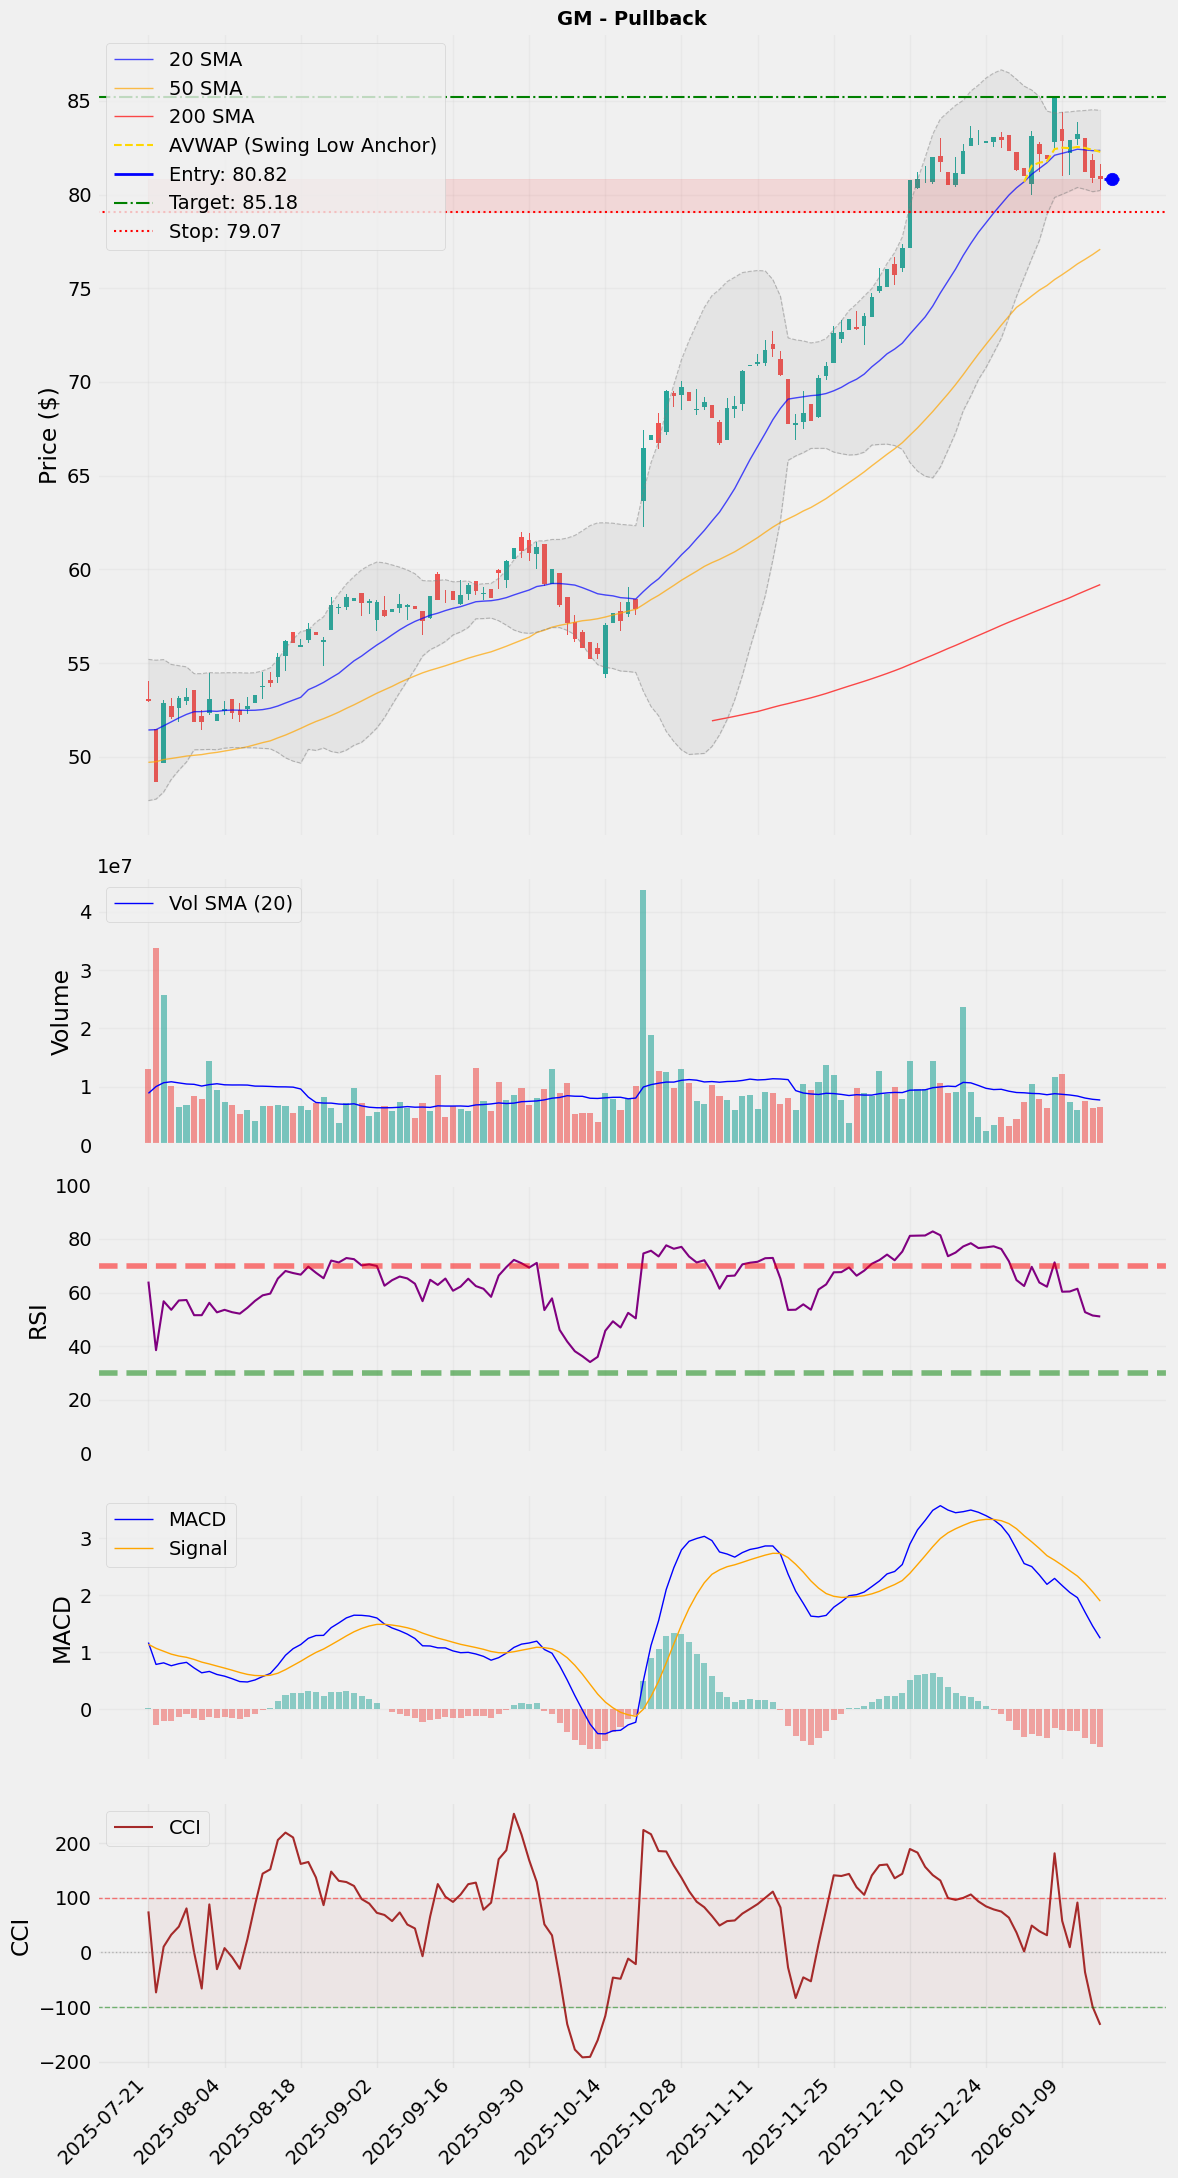

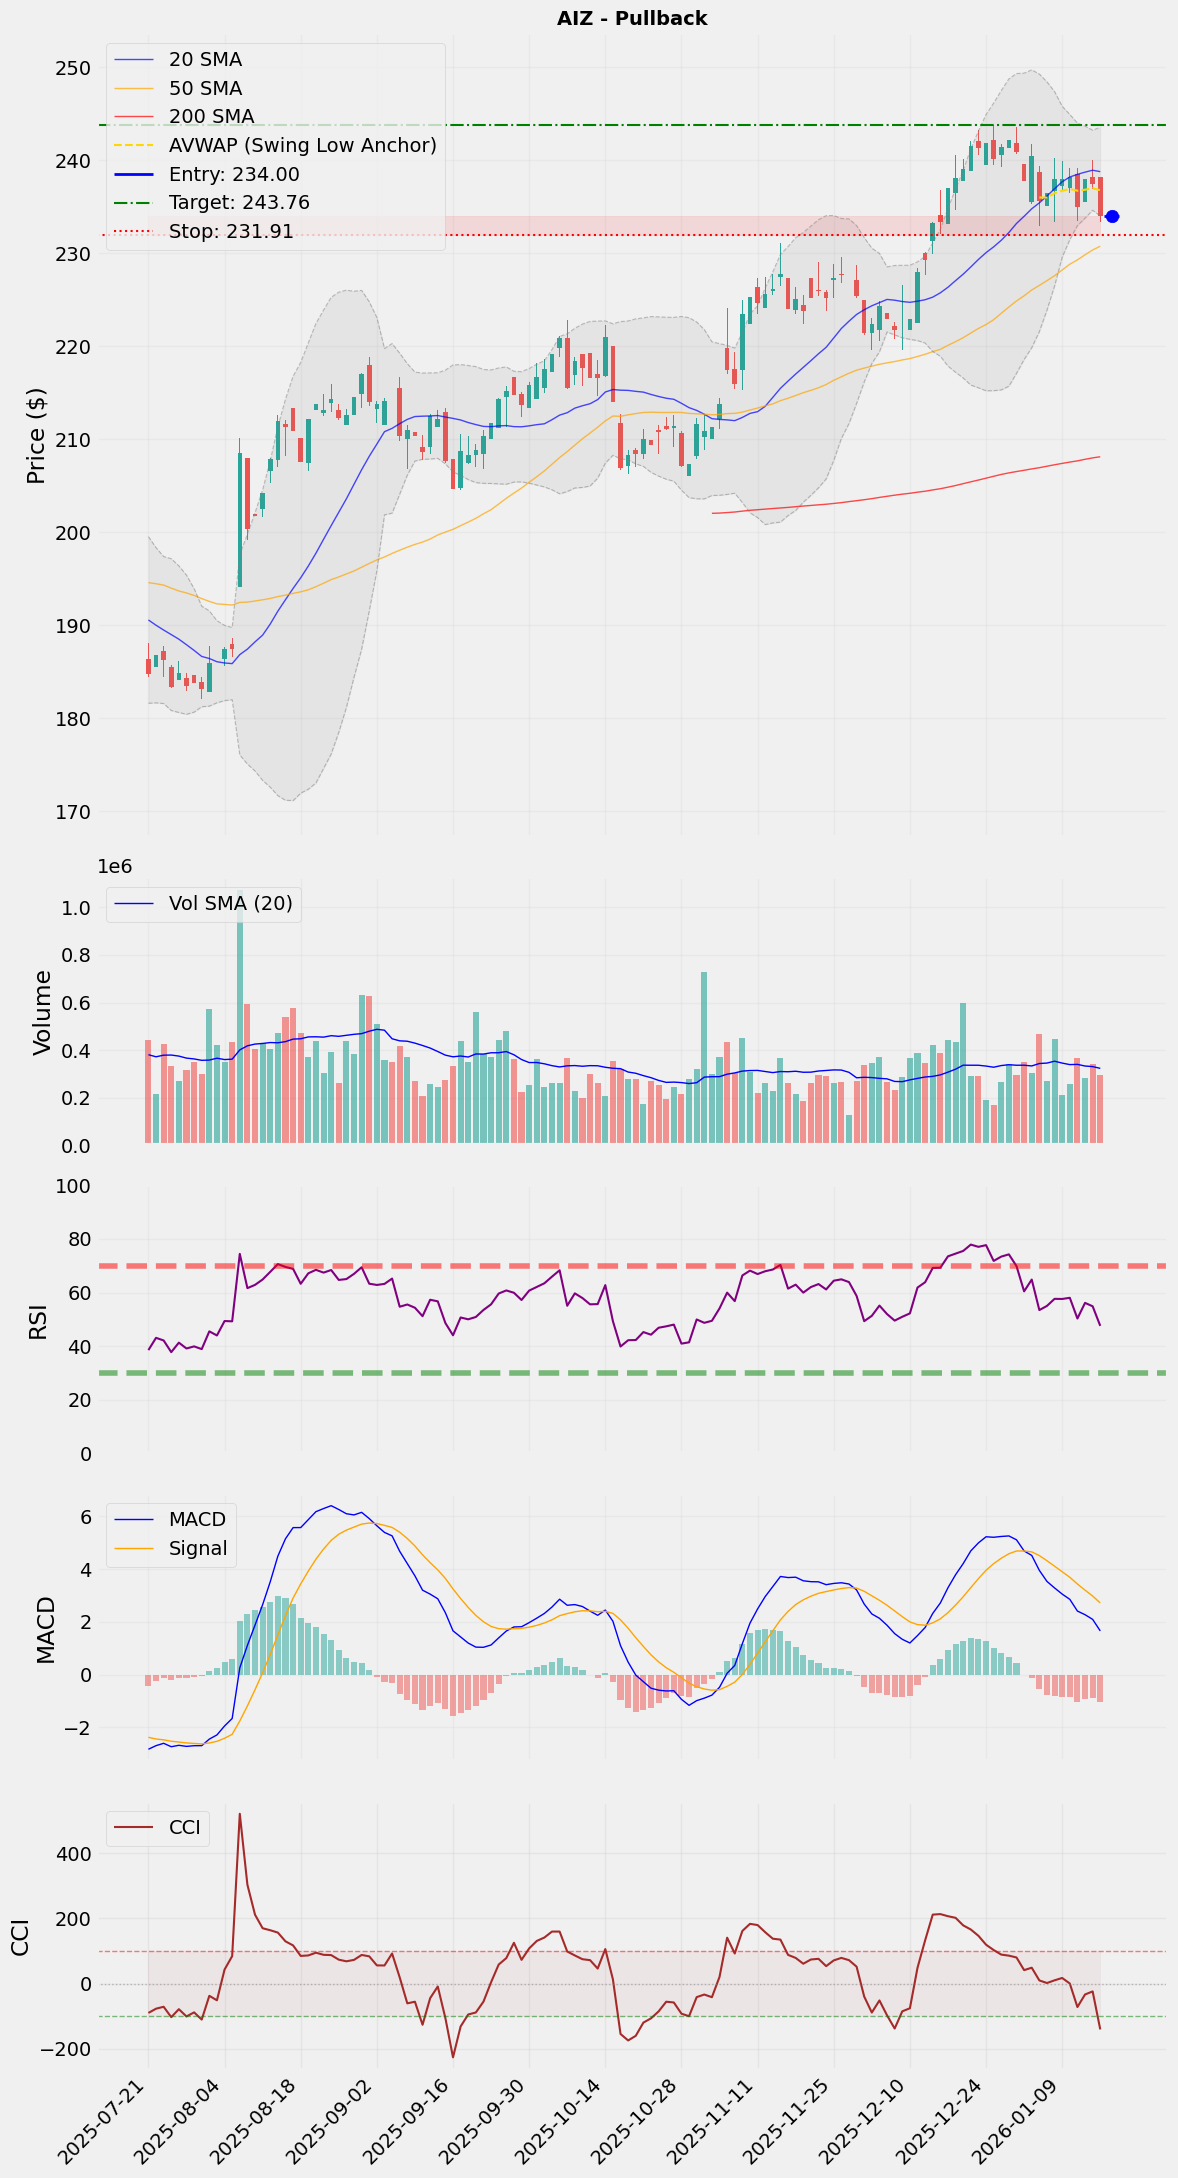

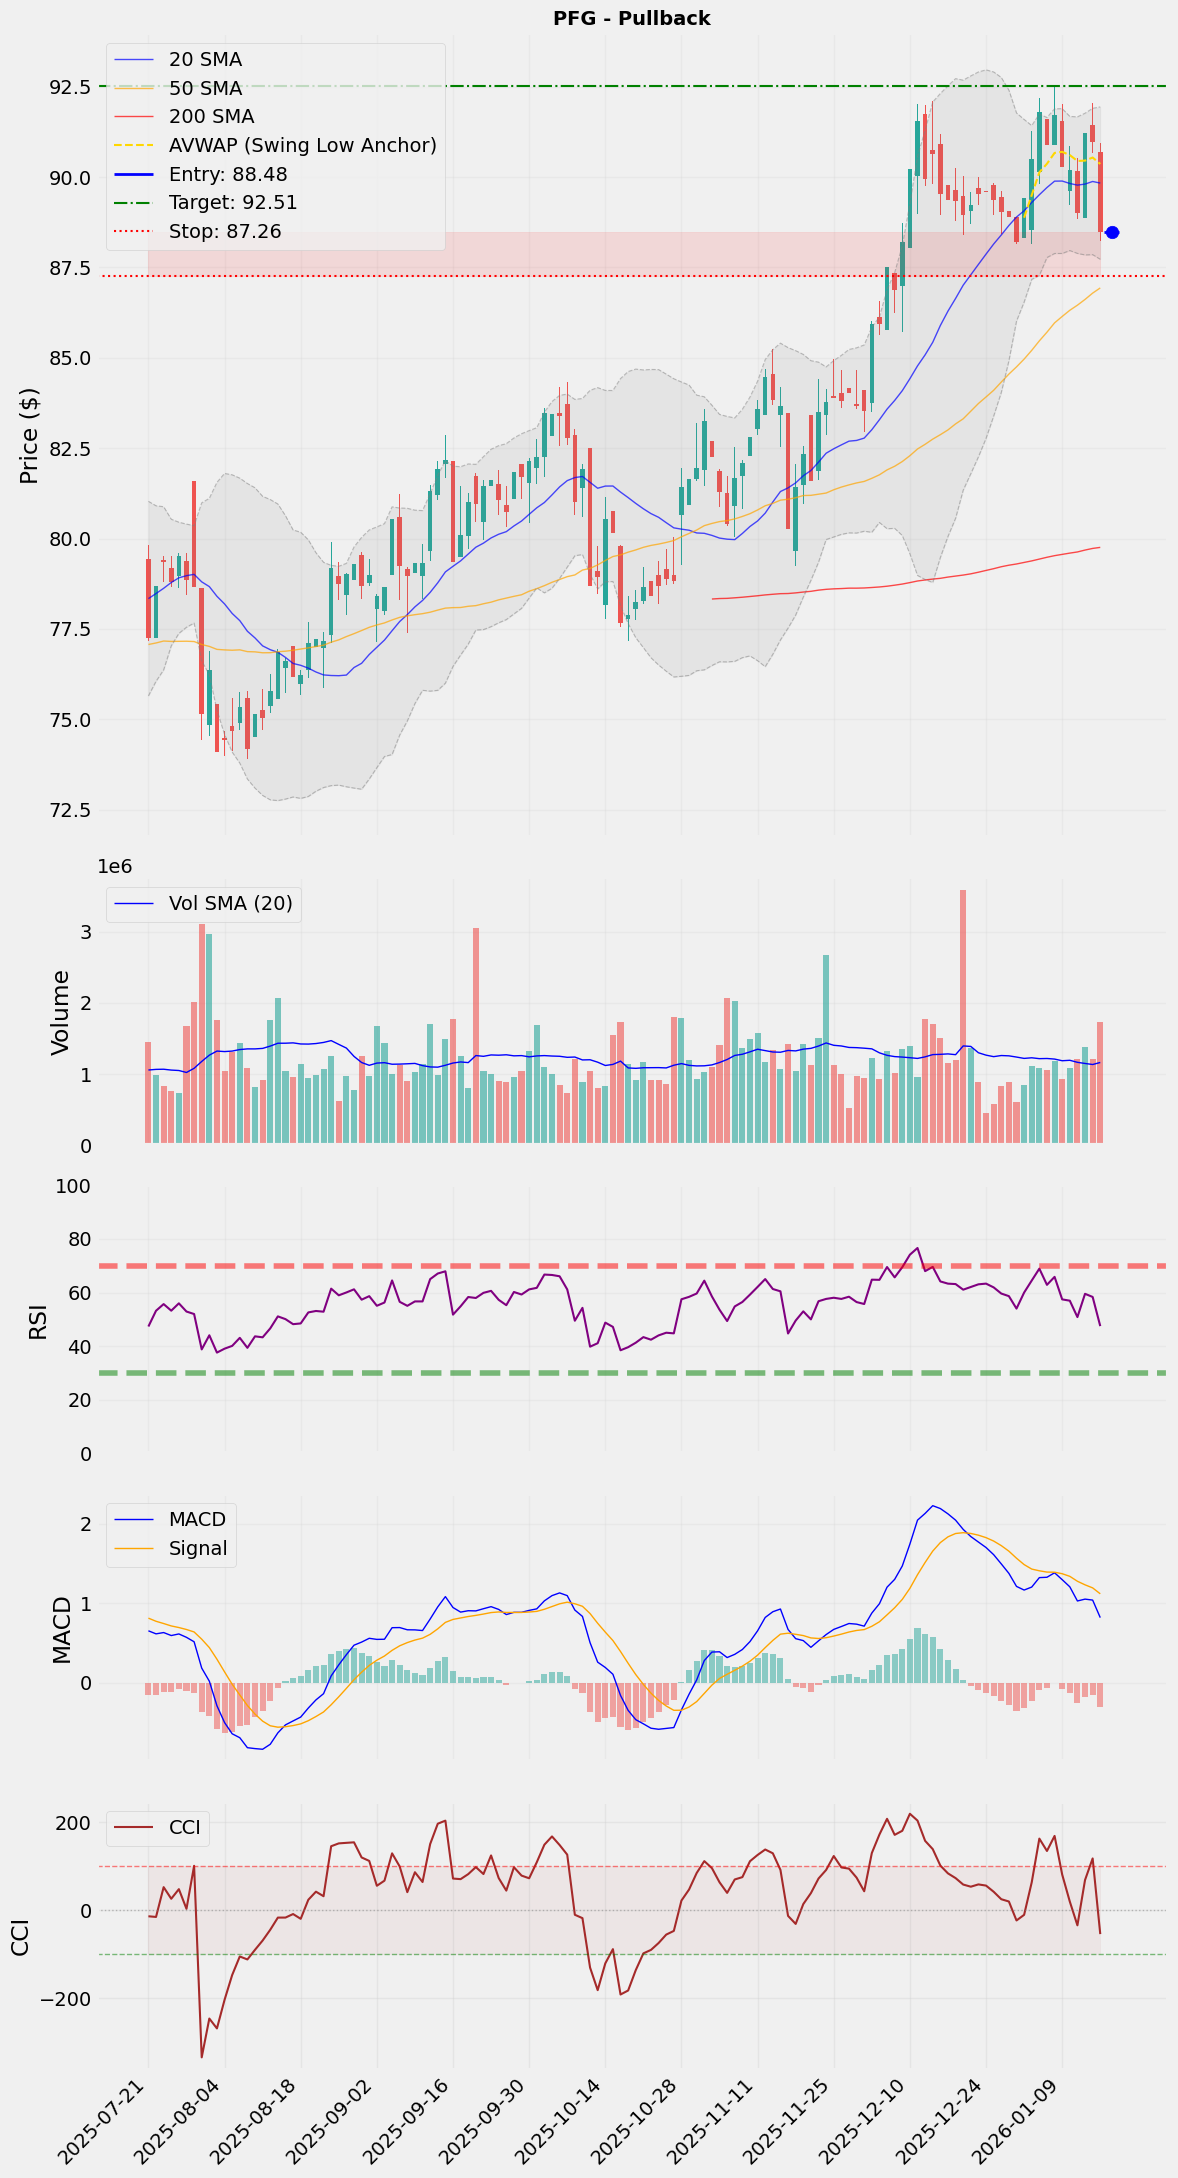


--- Charting Other Top Setups ---


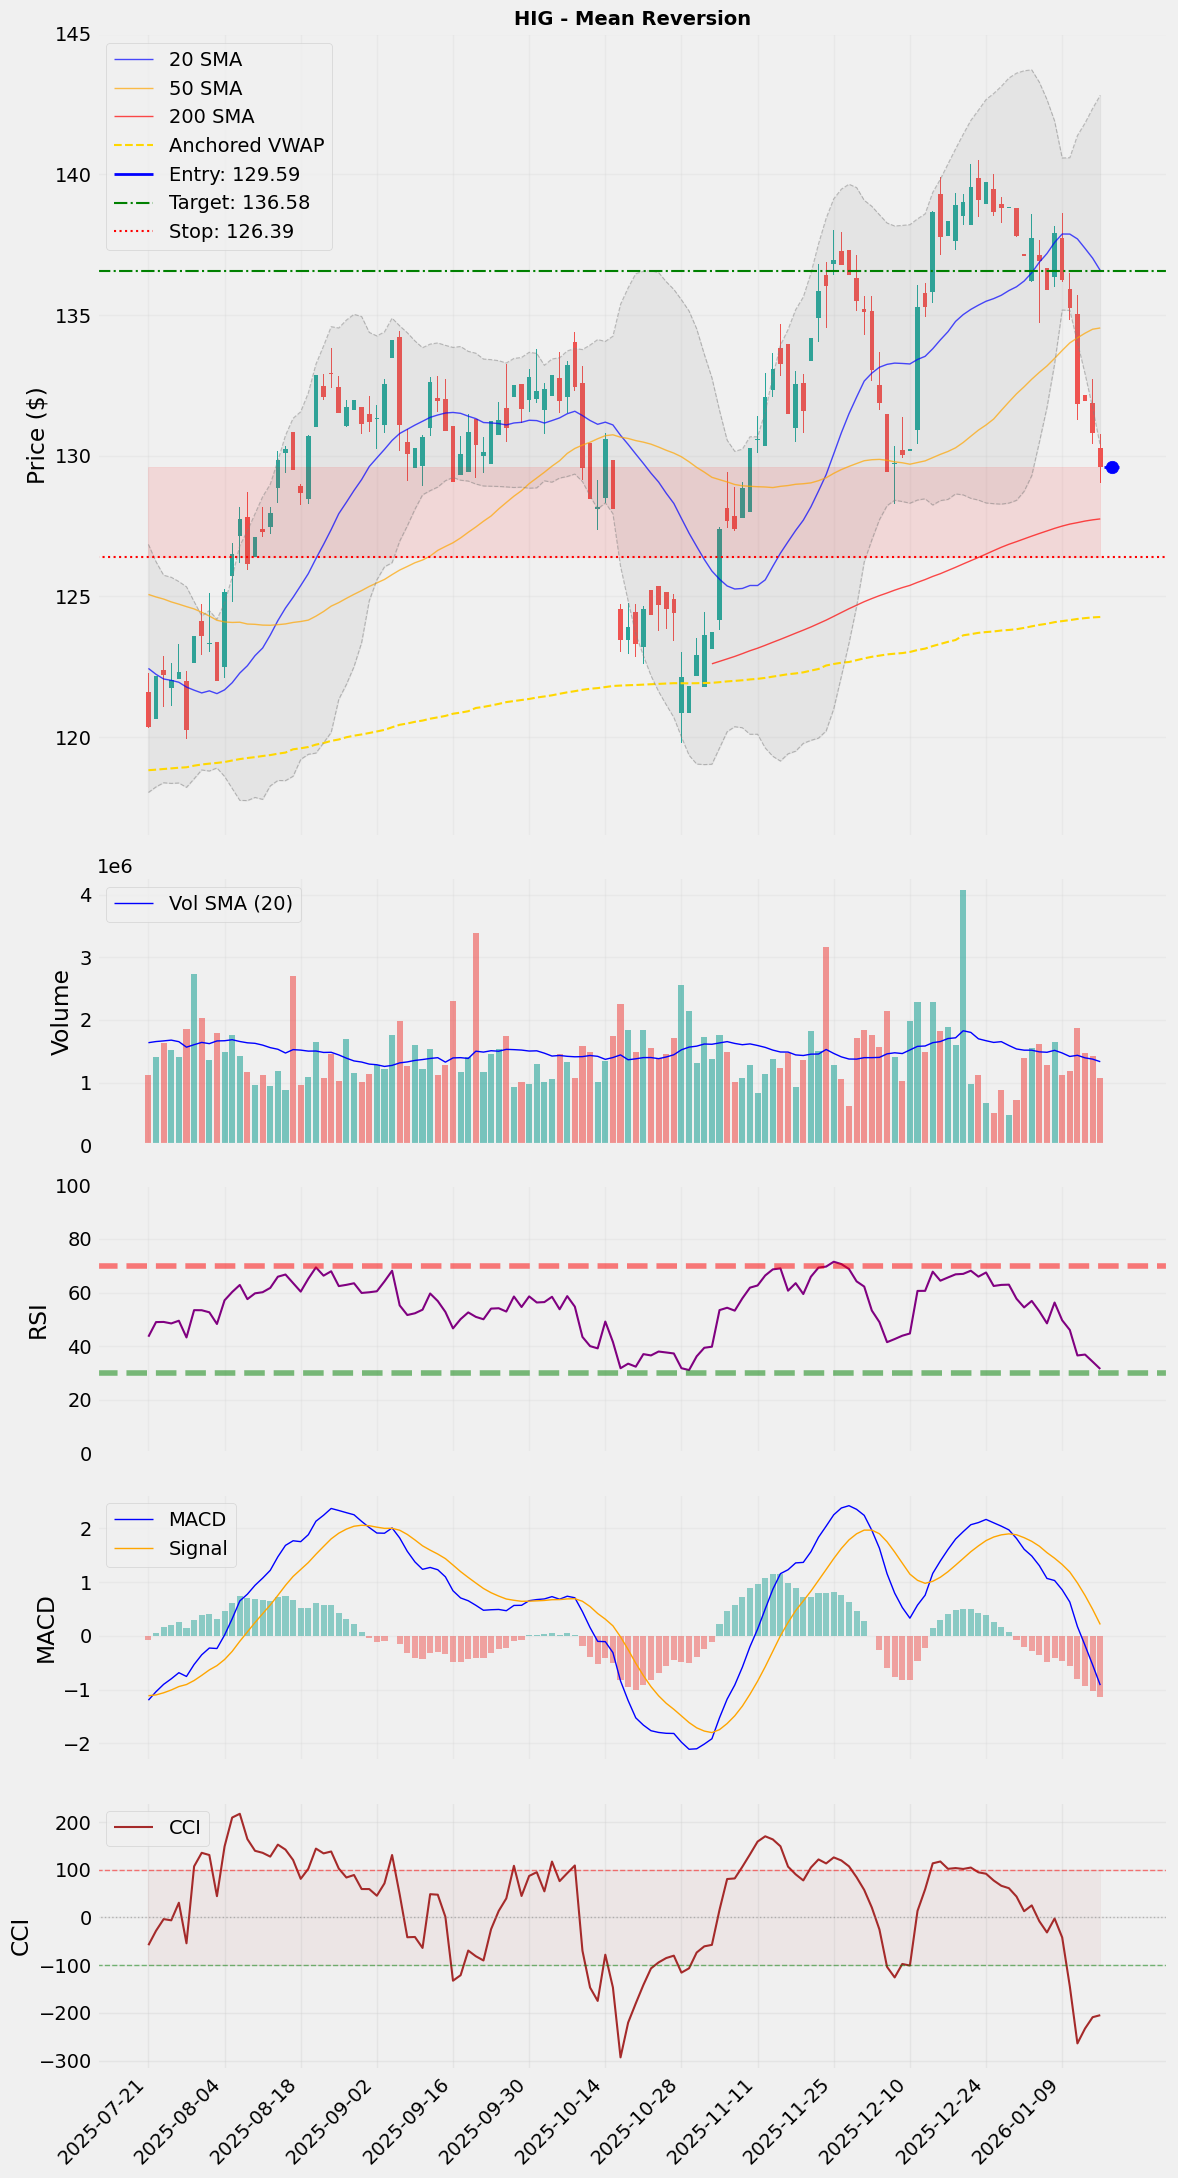

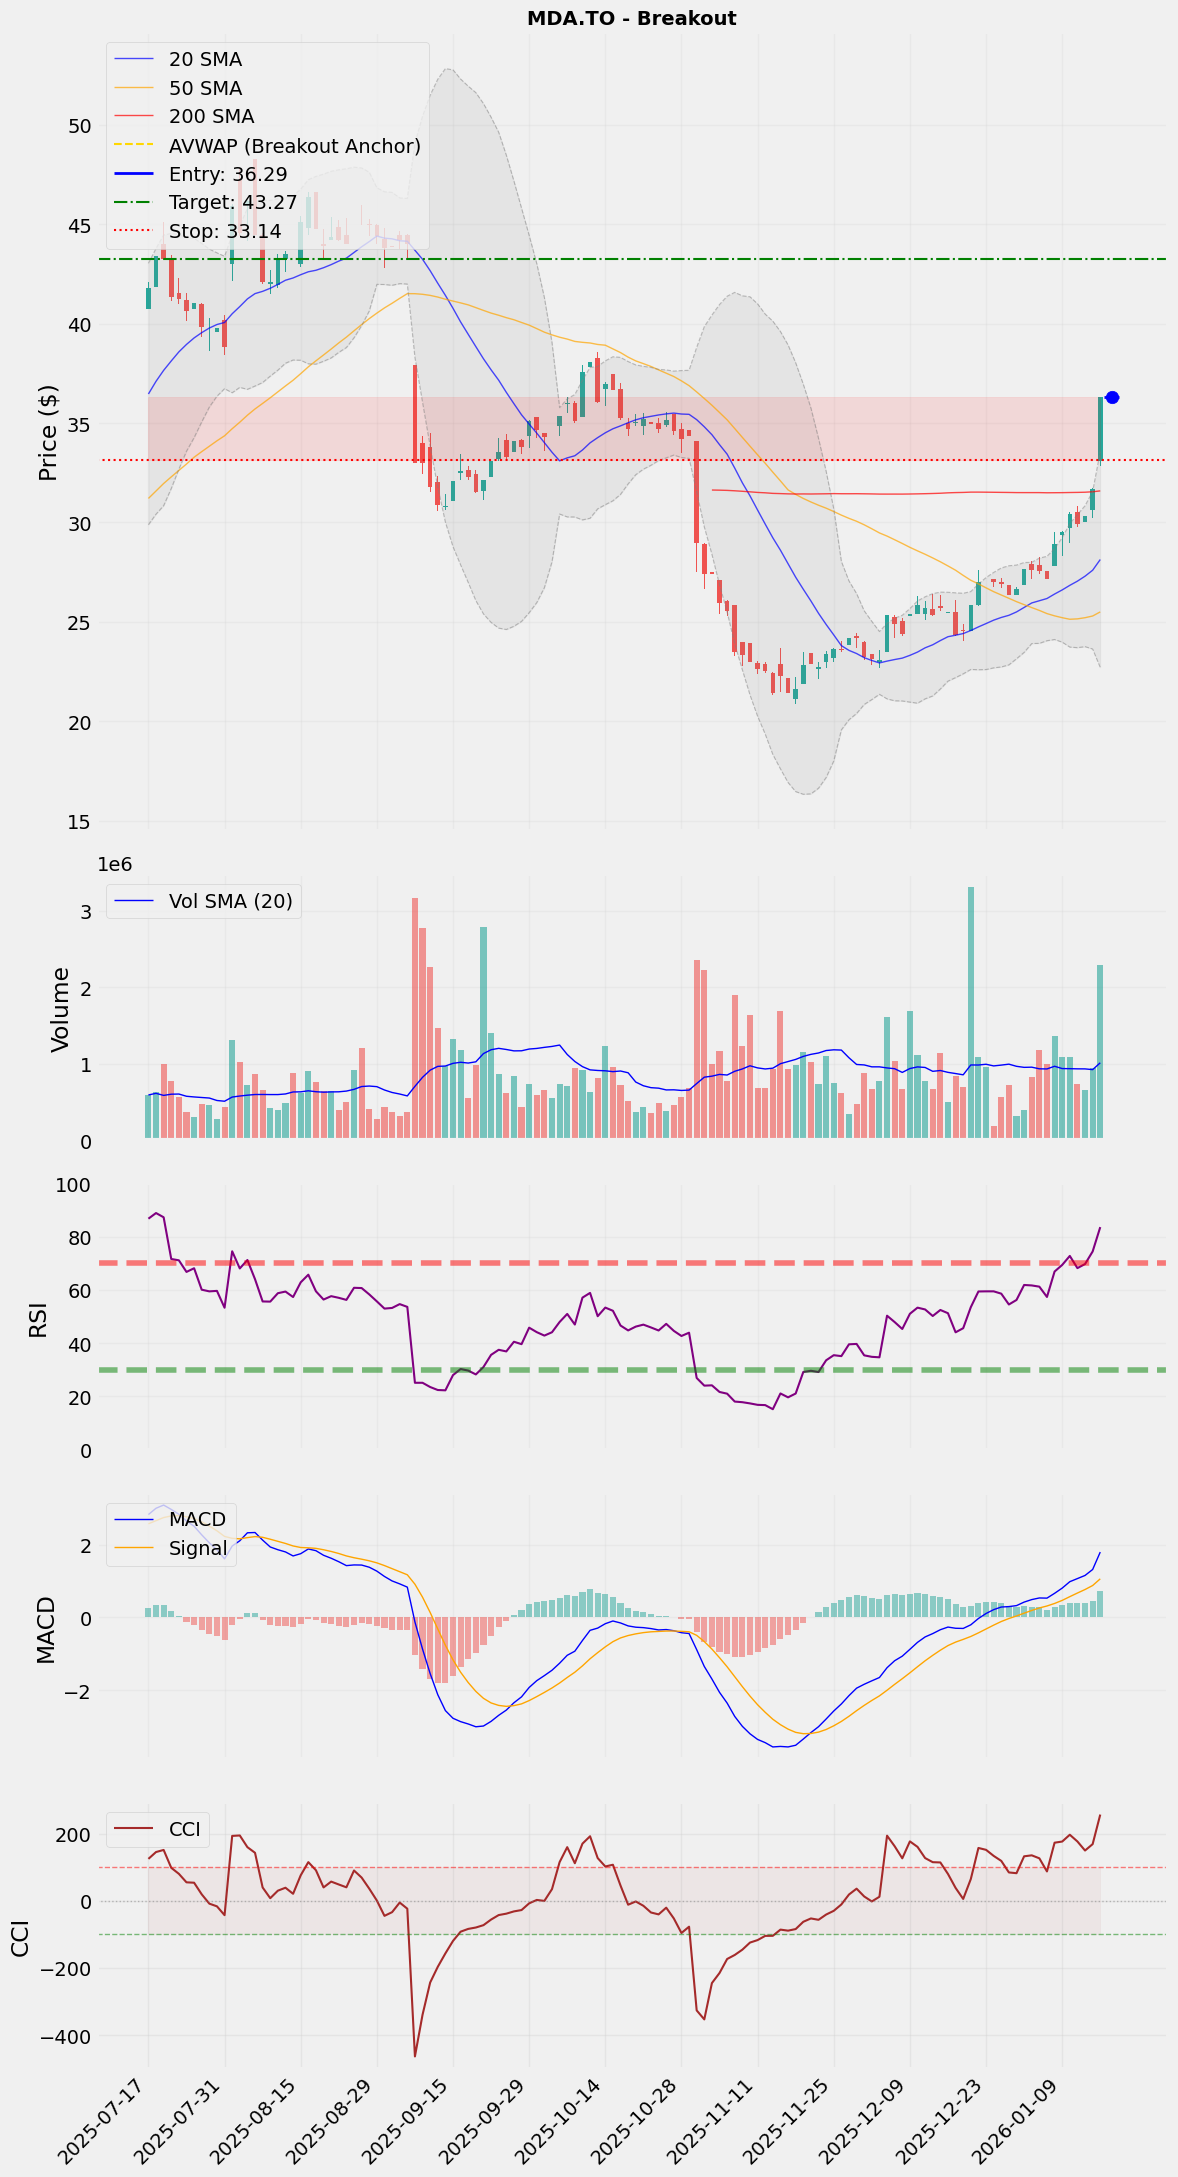

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np


def plot_candidate(ticker, df, signal_type, target=None, stop=None, entry_price=None):
    # Slice last 6 months
    plot_df = df.iloc[-126:].copy()
    plot_df = plot_df.reset_index()  # Reset index to use integer indexing for bars
    
    # Create 5 subplots: Price, Volume, RSI, MACD, CCI
    fig, (ax1, ax_vol, ax2, ax3, ax4) = plt.subplots(
        5,
        1,
        figsize=(12, 22),
        sharex=True,
        gridspec_kw={'height_ratios': [3, 1, 1, 1, 1]},
    )
    
    # --- AX1: Candlestick Chart ---
    # Define width of candlestick elements
    width = 0.6
    width2 = 0.1
    
    # Define colors
    up_color = '#26a69a'   # Green
    down_color = '#ef5350' # Red
    
    # Separate up and down days
    up = plot_df[plot_df.Close >= plot_df.Open]
    down = plot_df[plot_df.Close < plot_df.Open]
    
    # Plot Up Candles
    ax1.bar(up.index, up.Close - up.Open, width, bottom=up.Open, color=up_color)
    ax1.bar(up.index, up.High - up.Close, width2, bottom=up.Close, color=up_color)
    ax1.bar(up.index, up.Low - up.Open, width2, bottom=up.Open, color=up_color)
    
    # Plot Down Candles - FIXED: Lower wick now draws correctly from Low upward
    ax1.bar(down.index, down.Close - down.Open, width, bottom=down.Open, color=down_color)
    ax1.bar(down.index, down.High - down.Open, width2, bottom=down.Open, color=down_color)
    ax1.bar(down.index, down.Close - down.Low, width2, bottom=down.Low, color=down_color)
    
    # Plot Moving Averages
    ax1.plot(plot_df.index, plot_df[f'SMA_{MA_SHORT}'], label=f'{MA_SHORT} SMA', color='blue', linewidth=1, alpha=0.7)
    ax1.plot(plot_df.index, plot_df[f'SMA_{MA_MED}'], label=f'{MA_MED} SMA', color='orange', linewidth=1, alpha=0.7)
    ax1.plot(plot_df.index, plot_df[f'SMA_{MA_LONG}'], label=f'{MA_LONG} SMA', color='red', linewidth=1, alpha=0.7)
    
    # Anchored VWAP - context-aware selection
    avwap_col = None
    sig_lower = (signal_type or '').lower()
    if 'breakout' in sig_lower or 'retest' in sig_lower:
        if 'AVWAP_Breakout' in plot_df.columns:
            avwap_col = 'AVWAP_Breakout'
    elif 'pullback' in sig_lower:
        if 'AVWAP_Pullback' in plot_df.columns:
            avwap_col = 'AVWAP_Pullback'

    # Fallbacks
    if avwap_col is None:
        if 'AVWAP' in plot_df.columns:
            avwap_col = 'AVWAP'
        elif 'AVWAP_Global' in plot_df.columns:
            avwap_col = 'AVWAP_Global'

    if avwap_col is not None and avwap_col in plot_df.columns:
        label = 'Anchored VWAP'
        if avwap_col == 'AVWAP_Breakout':
            label = 'AVWAP (Breakout Anchor)'
        elif avwap_col == 'AVWAP_Pullback':
            label = 'AVWAP (Swing Low Anchor)'
        ax1.plot(plot_df.index, plot_df[avwap_col], label=label, color='gold', linestyle='--', linewidth=1.5)

    # Bollinger Bands
    if 'BB_Upper' in plot_df.columns:
        ax1.plot(plot_df.index, plot_df['BB_Upper'], color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
        ax1.plot(plot_df.index, plot_df['BB_Lower'], color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
        ax1.fill_between(plot_df.index, plot_df['BB_Upper'], plot_df['BB_Lower'], color='gray', alpha=0.1)

    # Visuals: Targets & Stops
    last_idx = plot_df.index[-1]
    if entry_price:
        # Draw entry as a small marker to the RIGHT of the last candle, not on top
        ax1.scatter(last_idx + 1.5, entry_price, color='blue', s=80, zorder=5, marker='o')
        ax1.hlines(entry_price, last_idx + 0.5, last_idx + 2.5, colors='blue', linewidth=2, label=f'Entry: {entry_price:.2f}')
    if target:
        ax1.axhline(target, color='green', linestyle='-.', linewidth=1.5, label=f'Target: {target:.2f}')
    if stop:
        ax1.axhline(stop, color='red', linestyle=':', linewidth=1.5, label=f'Stop: {stop:.2f}')
        # Only shade risk area if both stop and entry exist
        if entry_price:
            ax1.fill_between(plot_df.index, stop, entry_price, color='red', alpha=0.1)

    ax1.set_title(f"{ticker} - {signal_type}", fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price ($)')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.2)
    
    # --- AX_VOL: Volume ---
    ax_vol.bar(plot_df.index, plot_df['Volume'], color=np.where(plot_df['Close'] >= plot_df['Open'], up_color, down_color), alpha=0.6)
    
    # Add Volume SMA
    if 'Vol_SMA' in plot_df.columns:
        ax_vol.plot(plot_df.index, plot_df['Vol_SMA'], color='blue', linewidth=1, label='Vol SMA (20)')
        ax_vol.legend(loc='upper left')
    
    ax_vol.set_ylabel('Volume')
    ax_vol.grid(True, alpha=0.2)
    
    # --- AX2: RSI ---
    ax2.plot(plot_df.index, plot_df['RSI'], color='purple', linewidth=1.5, label='RSI')
    ax2.axhline(70, color='red', linestyle='--', alpha=0.5)
    ax2.axhline(30, color='green', linestyle='--', alpha=0.5)
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)
    ax2.grid(True, alpha=0.2)
    
    # --- AX3: MACD ---
    ax3.plot(plot_df.index, plot_df['MACD'], color='blue', linewidth=1, label='MACD')
    ax3.plot(plot_df.index, plot_df['MACD_Signal'], color='orange', linewidth=1, label='Signal')
    ax3.bar(plot_df.index, plot_df['MACD_Hist'], color=np.where(plot_df['MACD_Hist'] >= 0, up_color, down_color), alpha=0.5)
    ax3.set_ylabel('MACD')
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.2)

    # --- AX4: CCI ---
    if 'CCI' in plot_df.columns:
        ax4.plot(plot_df.index, plot_df['CCI'], label='CCI', color='brown', linewidth=1.5)
        ax4.axhline(100, color='red', linestyle='--', linewidth=1, alpha=0.5)
        ax4.axhline(-100, color='green', linestyle='--', linewidth=1, alpha=0.5)
        ax4.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        ax4.fill_between(plot_df.index, 100, -100, color='brown', alpha=0.05)
        ax4.set_ylabel('CCI')
        ax4.legend(loc='upper left')
        ax4.grid(True, alpha=0.3)
    
    # Robust date column detection
    ticks = np.arange(0, len(plot_df), 10)
    ax4.set_xticks(ticks)
    
    # Find the date column dynamically
    date_col = None
    for col in ['Date', 'index', 'Datetime']:
        if col in plot_df.columns:
            try:
                if pd.api.types.is_datetime64_any_dtype(plot_df[col]):
                    date_col = col
                    break
            except Exception:
                continue
    
    if date_col:
        ax4.set_xticklabels(plot_df[date_col].iloc[ticks].dt.strftime('%Y-%m-%d'), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()


# Run the plotter on the results
if 'results_df' in locals() and not results_df.empty:
    
    # 1. Plot Pullbacks
    pullback_df = results_df[results_df['Signal'] == 'Pullback'].head(3)
    if not pullback_df.empty:
        print(f"\n--- Charting Top Pullback Setups ---")
        for index, row in pullback_df.iterrows():
            ticker = row['Ticker']
            if ticker in data_store:
                plot_candidate(ticker, data_store[ticker], row['Signal'], row.get('Target'), row.get('Stop'), row.get('Close'))

    # 2. Plot Retests
    retest_df = results_df[results_df['Signal'] == 'Retest'].head(3)
    if not retest_df.empty:
        print(f"\n--- Charting Top Retest Setups ---")
        for index, row in retest_df.iterrows():
            ticker = row['Ticker']
            if ticker in data_store:
                plot_candidate(ticker, data_store[ticker], row['Signal'], row.get('Target'), row.get('Stop'), row.get('Close'))
                
    # 3. Plot Others (Optional, maybe top 2)
    other_df = results_df[~results_df['Signal'].isin(['Pullback', 'Retest'])].head(2)
    if not other_df.empty:
        print(f"\n--- Charting Other Top Setups ---")
        for index, row in other_df.iterrows():
            ticker = row['Ticker']
            if ticker in data_store:
                plot_candidate(ticker, data_store[ticker], row['Signal'], row.get('Target'), row.get('Stop'), row.get('Close'))

else:
    print("No Candidates to plot. ")

# Manual Chart Analysis Tool

This cell provides an interactive tool for manual analysis of any stock, allowing users to generate detailed technical charts on-demand:

- **Ticker Selection**: Users can specify any ticker symbol (e.g., 'NVDA', 'TSLA', 'SHOP.TO') by modifying the `ticker_to_plot` variable. The code includes examples and comments for easy customization.

- **Data Retrieval Logic**: First checks if the ticker data is already cached from the scanner run (`data_store`). If not available, it downloads fresh data using the `download_data()` function and processes it with `calculate_indicators()` and `apply_strategies()`.

- **Signal Detection**: Analyzes the latest data point to determine if any active trading signals are present, updating the chart title accordingly (e.g., "Breakout (Active)", "Manual Analysis").

- **Chart Generation**: Uses the same `plot_candidate()` function as the automated charting, but focuses on manual analysis by passing the current close price as the entry point for visualization purposes.

- **Error Handling**: Provides clear feedback if data cannot be retrieved or processed, ensuring robust operation even with invalid tickers.

This tool enables traders to perform ad-hoc technical analysis on any stock of interest, complementing the automated scanner results with personalized research capabilities.

Generating chart for MFC.TO...


C:\Users\diksh\AppData\Local\Temp\ipykernel_15312\3542267247.py:323: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Breakout_Pivot'] = df['Breakout_Pivot'].fillna(method='ffill')


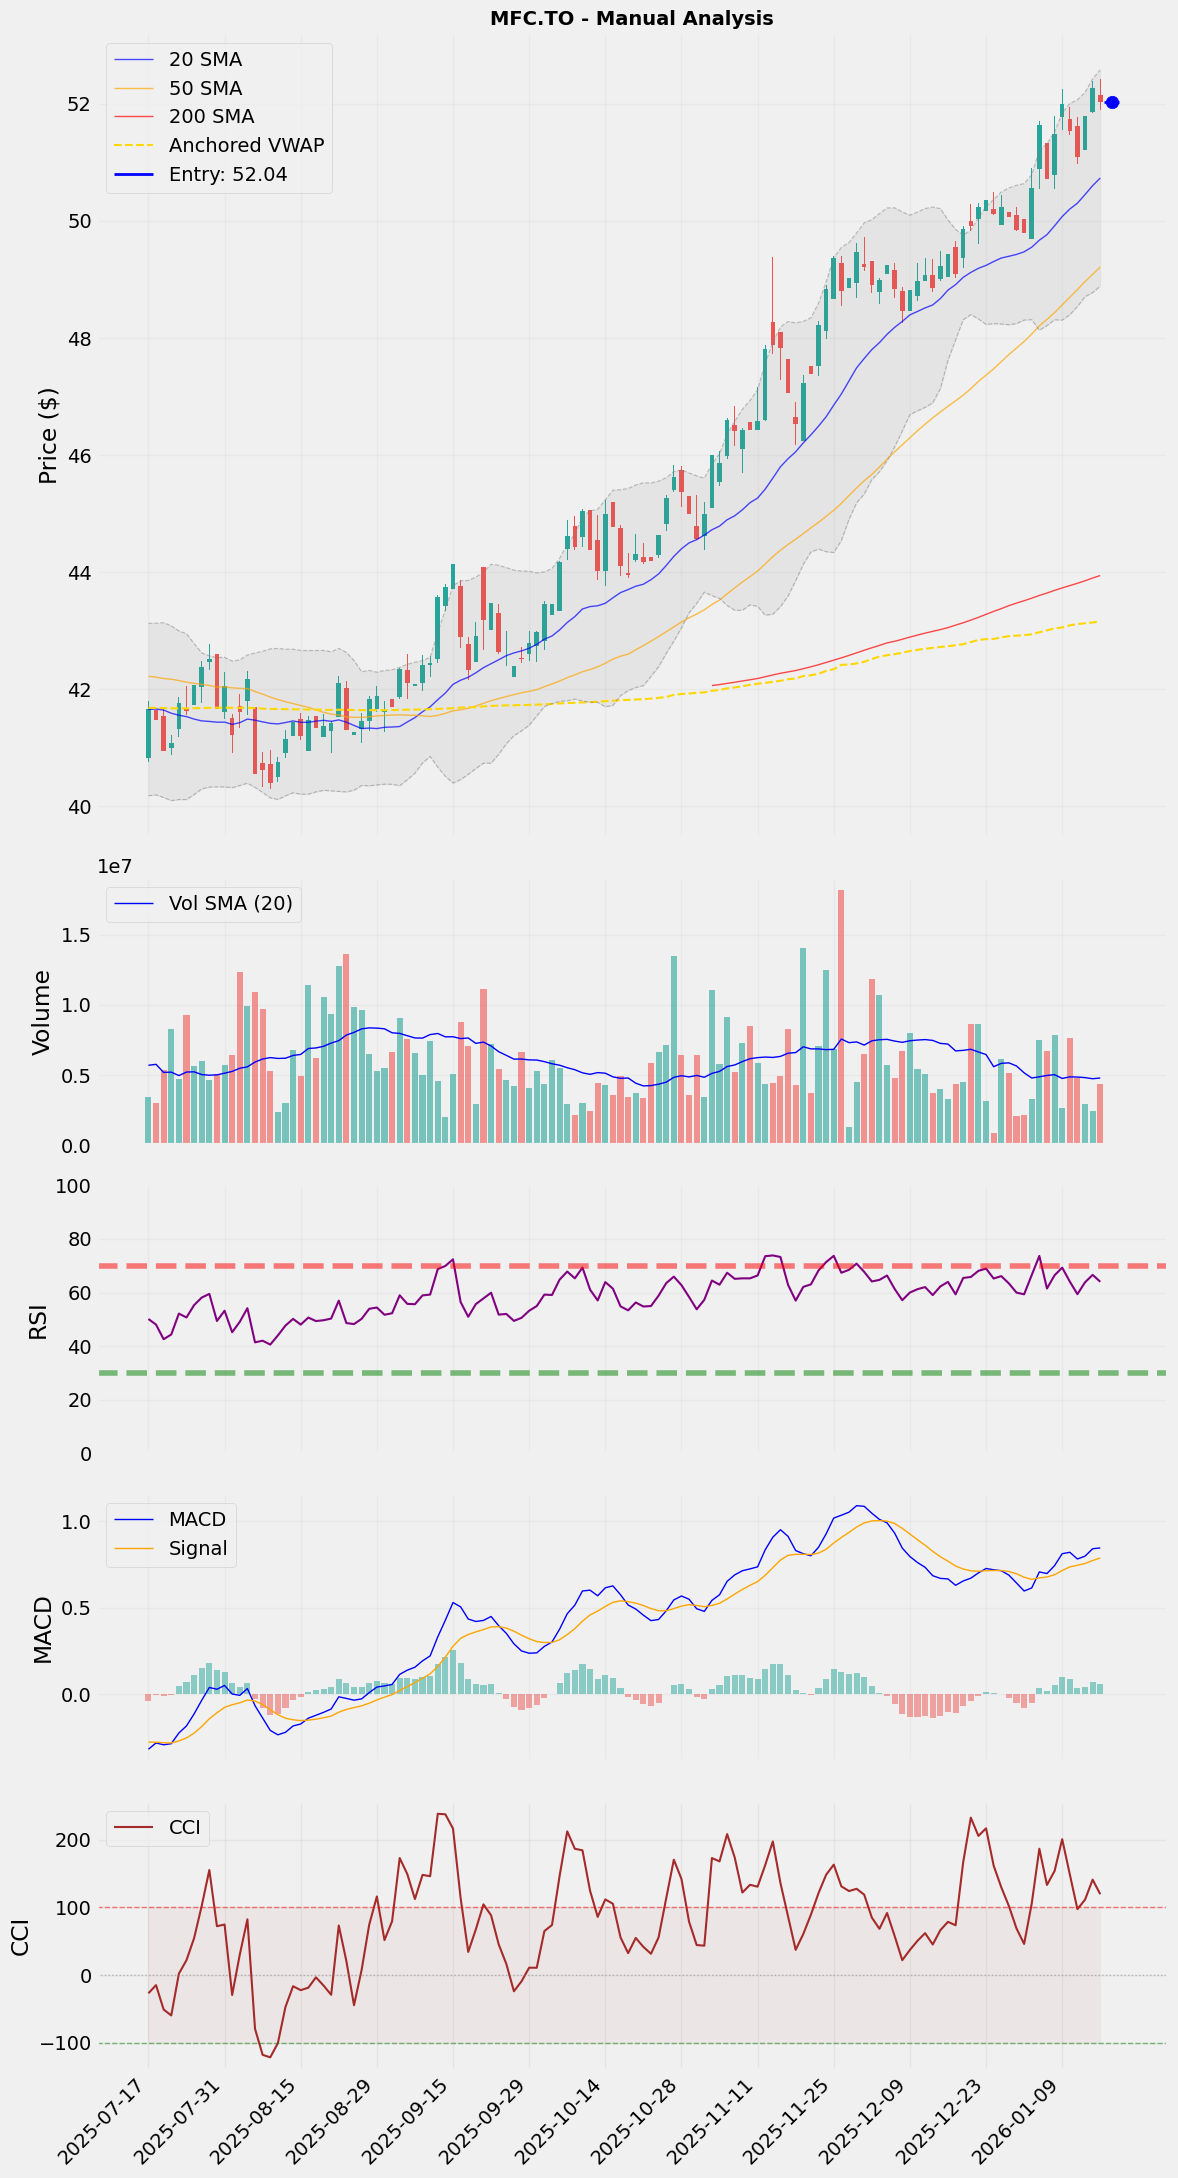

In [8]:
# --- Manual Charting ---
# Enter the ticker symbol you want to analyze
ticker_to_plot = 'MFC.TO'  # <--- Change this to your desired stock (e.g., 'NVDA', 'TSLA', 'SHOP.TO')

print(f"Generating chart for {ticker_to_plot}...")

# 1. Get Data
# Check if we already have the data from the scanner loop
if 'data_store' in locals() and ticker_to_plot in data_store:
    df_plot = data_store[ticker_to_plot]
    # Force re-calculation to ensure new indicators are present
    df_plot = calculate_indicators(df_plot)
    df_plot = apply_strategies(df_plot)
    df_plot = add_anchored_vwaps(df_plot)
else:
    # Download if not in memory
    print(f"Data not found in cache. Downloading {ticker_to_plot}...")
    data_dict = download_data([ticker_to_plot], START_DATE, END_DATE)
    if ticker_to_plot in data_dict:
        df_plot = calculate_indicators(data_dict[ticker_to_plot])
        # Apply strategies to see if any signals exist
        df_plot = apply_strategies(df_plot)
        df_plot = add_anchored_vwaps(df_plot)
    else:
        df_plot = None
        print(f"Could not find data for {ticker_to_plot}")

# 2. Plot
if df_plot is not None and not df_plot.empty:
    # Check for active signals to display context
    latest_manual = df_plot.iloc[-1]
    manual_signal = "Manual Analysis"
    
    # Check if any strategy signals are active right now
    if 'Signal_Breakout' in df_plot.columns:
        if latest_manual['Signal_Breakout']: manual_signal = "Breakout (Active)"
        elif latest_manual['Signal_Pullback']: manual_signal = "Pullback (Active)"
        elif latest_manual['Signal_MeanRev']: manual_signal = "Mean Reversion (Active)"
    
    # Plot using the helper function
    # We pass the current close as the 'entry' for visualization purposes
    
    plot_candidate(
        ticker_to_plot, 
        df_plot, 
        signal_type=manual_signal,
        target=None,
        stop=None,
        entry_price=latest_manual['Close'])
else:
    print("No data available to plot.")
